In [2]:
import tensorflow as tf

import numpy as np
import pandas as pd
import seaborn as sn
import datetime as dt
import scipy.signal as sig
import matplotlib.pyplot as plt

from typing import Tuple, List
from pathlib import Path
from tqdm import tqdm, trange

In [3]:
_DATA_PATH = Path("../data/USA/")

In [15]:
df = pd.read_csv(_DATA_PATH / "California.csv")
df.datetime = pd.to_datetime(df.datetime)
df.head(5)

datetime  COL    NG   NUC  OIL  OTH  SUN   WAT   WND  \
0 2018-07-01 08:00:00+00:00    7  7675  2267   87  506    0  2560  3958   
1 2018-07-01 09:00:00+00:00    9  5879  2261   87  540    0  2584  4087   
2 2018-07-01 10:00:00+00:00    6  5635  2258   87  515    0  2506  3710   
3 2018-07-01 11:00:00+00:00    8  5405  2257   87  566    0  2446  3630   
4 2018-07-01 12:00:00+00:00    8  5592  2260   87  569    0  2609  3156   

     MWh  carbon_footprint  carbon_per_MWh  
0  17060      3.258580e+06      191.007063  
1  15447      2.519397e+06      163.099425  
2  14717      2.415664e+06      164.141088  
3  14399      2.322766e+06      161.314427  
4  14281      2.399941e+06      168.051330

In [16]:
df.dtypes

datetime            datetime64[ns, UTC]
COL                               int64
NG                                int64
NUC                               int64
OIL                               int64
OTH                               int64
SUN                               int64
WAT                               int64
WND                               int64
MWh                               int64
carbon_footprint                float64
carbon_per_MWh                  float64
dtype: object

In [5]:
data = df.carbon_per_MWh.to_numpy()
data.shape

(33864,)

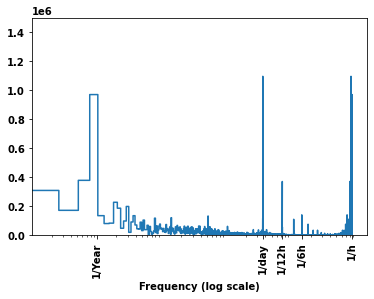

In [6]:
fft = np.abs(np.fft.fft(data))
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(data)
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 1.5e6)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524, 365.2524*2, 365.2524*4, 365.2524*24], labels=['1/Year', '1/day', '1/12h', '1/6h', '1/h'], rotation=90)
plt.xlabel('Frequency (log scale)')
plt.show()

In [49]:
timestamp_s = df.datetime.map(dt.datetime.timestamp)

day = 24 * 60 * 60
year = 365.2425 * day

df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

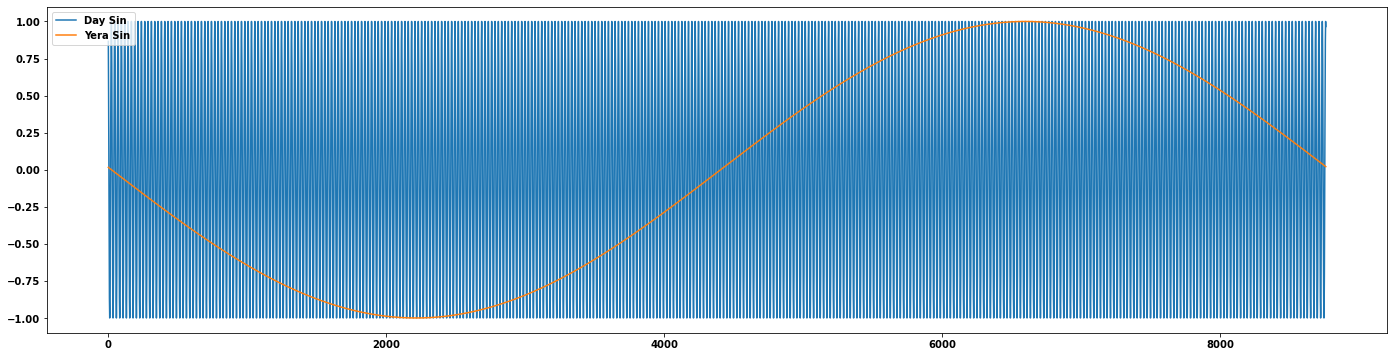

In [68]:
plt.figure(figsize=(24,6))
plt.plot(df.day_sin[:365*24])
plt.plot(df.year_sin[:365*24])
plt.legend(["Day Sin", "Yera Sin"])
plt.show()

In [149]:
def generate_lstm_model(layers: List[int], output_len: int):
    
    model = tf.keras.models.Sequential()
    
    for units in layers[:-1]:
        model.add(tf.keras.layers.LSTM(units=units, return_sequences=True))
    
    model.add(tf.keras.layers.LSTM(units=layers[-1], return_sequences=False))
    
    model.add(tf.keras.layers.Dense(units=output_len*1))
    model.add(tf.keras.layers.Reshape([output_len, 1]))
    
    return model



def generate_data(df: pd.DataFrame, input_len: int, output_len: int, x_cols: List[str] = ..., y_cols: List[str] = ..., val_ratio: float = 0.2):
    
    if x_cols is Ellipsis:
        x_cols = ["carbon_per_MWh", "day_sin", "day_cos", "year_sin", "year_cos"]
    if y_cols is Ellipsis:
        y_cols = ["carbon_per_MWh"]
    
    data_X = df.loc[:, x_cols].to_numpy().reshape(-1, len(x_cols))
    data_y = df.loc[:, y_cols].to_numpy().reshape(-1, len(y_cols))
    
    X = []
    y = []

    for i in range(input_len, data_X.shape[0]-output_len):
        inp = data_X[i-input_len:i, :]
        out = data_y[i:i+output_len, :]
        X.append(inp)
        y.append(out)

    X = np.array(X).reshape(-1, input_len, len(x_cols))
    y = np.array(y).reshape(-1, output_len, len(y_cols))
    
    val_len = int(val_ratio * X.shape[0])
    train_X = X[:-val_len, ...]
    train_y = y[:-val_len, ...]
    val_X = X[-val_len:, ...]
    val_y = y[-val_len:, ...]
    
    print([a.shape for a in (train_X, train_y, val_X, val_y)])
    
    return (train_X, train_y), (val_X, val_y)



def plot_history(history: tf.keras.callbacks.History):
    f, ax = plt.subplots(2, 1, figsize=(16,8))
    ax[0].plot(history.history["loss"], label="train")
    ax[0].plot(history.history["val_loss"], label="val")
    ax[0].set_title("MSE Loss")
    ax[0].legend()
    ax[1].plot(history.history["mean_absolute_error"], label="train")
    ax[1].plot(history.history["val_mean_absolute_error"], label="val")
    ax[1].set_title("MAE Loss")
    ax[1].legend()
    plt.show()



def compile_and_fit(model: tf.keras.Model, X: np.ndarray, y: np.ndarray, val: Tuple[np.ndarray], max_epochs: int = 20, patience: int = 2):

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)
    model.compile(loss="mse", optimizer="adam", metrics=["mae"])
    history = model.fit(X, y, epochs=max_epochs, validation_data=val, callbacks=[early_stopping])
    
    return history



def fit_lstm(input_len: int, output_len: int, layers: List[int],
             df: pd.DataFrame, x_cols: List[str] = ..., y_cols: List[str] = ..., val_ratio: float = 0.2,
             max_epochs: int = 20, patience: int = 2):
    
    if x_cols is Ellipsis:
        x_cols = ["carbon_per_MWh", "day_sin", "day_cos", "year_sin", "year_cos"]
    if y_cols is Ellipsis:
        y_cols = ["carbon_per_MWh"]
    
    lstm = generate_lstm_model(layers=layers, output_len=output_len)
    (X, y), val_Xy = generate_data(df=df, input_len=input_len, output_len=output_len, x_cols=x_cols, y_cols=y_cols, val_ratio=val_ratio)
    history = compile_and_fit(model=lstm, X=X, y=y, val=val_Xy, max_epochs=max_epochs, patience=patience)
    plot_history(history=history)
    
    return_obj = {
        "model": lstm,
        "history": history,
        "hp": {
            "input_len": input_len,
            "output_len": output_len,
            "layers": layers,
            "x_cols": x_cols,
            "y_cols": y_cols,
            "val_ratio": val_ratio,
            "max_epochs": max_epochs,
            "patience": patience
        }
    }
    
    return return_obj

In [150]:
df_train = df.loc[df.datetime.dt.year < 2022]
df_test = df.loc[df.datetime.dt.year >= 2022]

df_train.shape, df_test.shape

((30712, 16), (3152, 16))

[(24532, 24, 5), (24532, 24, 1), (6132, 24, 5), (6132, 24, 1)]
Train on 24532 samples, validate on 6132 samples
Epoch 1/50
24532/24532 [==============================] - 19s 770us/sample - loss: 60391.7343 - mean_absolute_error: 231.8265 - val_loss: 53608.5746 - val_mean_absolute_error: 221.9616
Epoch 2/50
24532/24532 [==============================] - 17s 710us/sample - loss: 50290.1705 - mean_absolute_error: 208.9080 - val_loss: 44241.5698 - val_mean_absolute_error: 199.7496
Epoch 3/50
24532/24532 [==============================] - 17s 689us/sample - loss: 41715.3953 - mean_absolute_error: 187.2722 - val_loss: 36234.7454 - val_mean_absolute_error: 178.5865
Epoch 4/50
24532/24532 [==============================] - 17s 701us/sample - loss: 34350.5268 - mean_absolute_error: 166.6669 - val_loss: 29339.1389 - val_mean_absolute_error: 158.1069
Epoch 5/50
24532/24532 [==============================] - 18s 734us/sample - loss: 28040.6591 - mean_absolute_error: 147.3306 - val_loss: 23452.1912

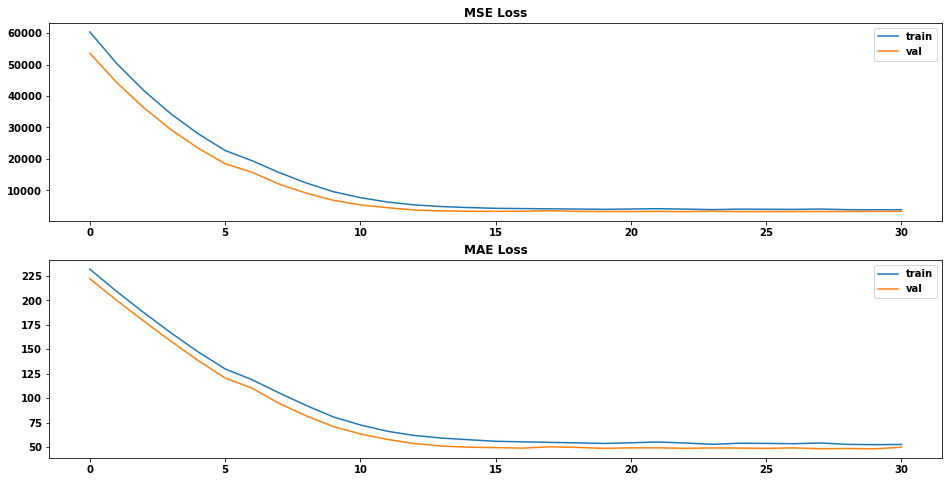

In [151]:
input_len = 24
output_len = 24
layers = [64]
max_epochs = 50
patience = 5

day2day = fit_lstm(input_len=input_len, output_len=output_len, layers=layers, df=df_train, max_epochs=max_epochs, patience=patience)

In [152]:
day2day

{'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x1ed90d1e888>,
 'history': <tensorflow.python.keras.callbacks.History at 0x1edad136588>,
 'hp': {'input_len': 24,
  'output_len': 24,
  'layers': [64],
  'x_cols': ['carbon_per_MWh', 'day_sin', 'day_cos', 'year_sin', 'year_cos'],
  'y_cols': ['carbon_per_MWh'],
  'val_ratio': 0.2,
  'max_epochs': 50,
  'patience': 5}}

In [131]:
m = day2day["model"]

In [153]:
df_test

datetime  COL     NG   NUC  OIL   OTH   SUN   WAT  \
30712 2022-01-01 00:00:00+00:00  241   8391  2265   44   856  1859  2766   
30713 2022-01-01 01:00:00+00:00  240  10896  2265   42  1858  1420  3700   
30714 2022-01-01 02:00:00+00:00  240  11952  2265   41  1828     0  4159   
30715 2022-01-01 03:00:00+00:00  240  12080  2265   43  1833     0  3630   
30716 2022-01-01 04:00:00+00:00  238  11981  2265   44  1719     0  3136   
...                         ...  ...    ...   ...  ...   ...   ...   ...   
33859 2022-05-12 03:00:00+00:00  615   8832  2283   46  2060   191  4646   
33860 2022-05-12 04:00:00+00:00  463   8758  2281   46  2201    64  4603   
33861 2022-05-12 05:00:00+00:00  301   8101  2281   46  1844    18  4177   
33862 2022-05-12 06:00:00+00:00  287   7257  2282   46  1436    17  3703   
33863 2022-05-12 07:00:00+00:00  285   6537  2283   46  1075    15  3303   

        WND    MWh  carbon_footprint  carbon_per_MWh       day_sin  \
30712  3334  19756      3.749188e+06      189.774661 -8.652299e-12   
30713  3183  23604      4.780054e+06      202.510355  2.588190e-01   
30714  2850  23335      5.214898e+06      223.479664  5.000000e-01   
30715  2689  22780      5.269655e+06      231.328153  7.071068e-01   
30716  2662  22045      5.227741e+06      237.139555  8.660254e-01   
...     ...    ...               ...             ...           ...   
33859  3368  22041      4.311361e+06      195.606395  7.071068e-01   
33860  3571  21987      4.127098e+06      187.706259  8.660254e-01   
33861  4154  20922      3.692118e+06      176.470601  9.659258e-01   
33862  4088  19116      3.329642e+06      174.180881  1.000000e+00   
33863  3823  17367      3.030476e+06      174.496239  9.659258e-01   

            day_cos  year_sin  year_cos  
30712  1.000000e+00  0.006709  0.999977  
30713  9.659258e-01  0.007426  0.999972  
30714  8.660254e-01  0.008143  0.999967  
30715  7.071068e-01  0.008859  0.999961  
30716  5.000000e-01  0.009576  0.999954  
...             ...       ...       ...  
33859  7.071068e-01  0.770209 -0.637791  
33860  5.000000e-01  0.769752 -0.638343  
33861  2.588190e-01  0.769294 -0.638895  
33862  1.079862e-12  0.768836 -0.639446  
33863 -2.588190e-01  0.768378 -0.639997  

[3152 rows x 16 columns]

In [190]:
test_X = df_test.loc[:,day2day["hp"]["x_cols"]].to_numpy()[:-(len(df_test)%24)].reshape(-1,24,len(day2day["hp"]["x_cols"])).astype(np.float32)
test_X.shape

(131, 24, 5)

In [194]:
preds = m.predict(test_X)
preds.shape

(131, 24, 1)

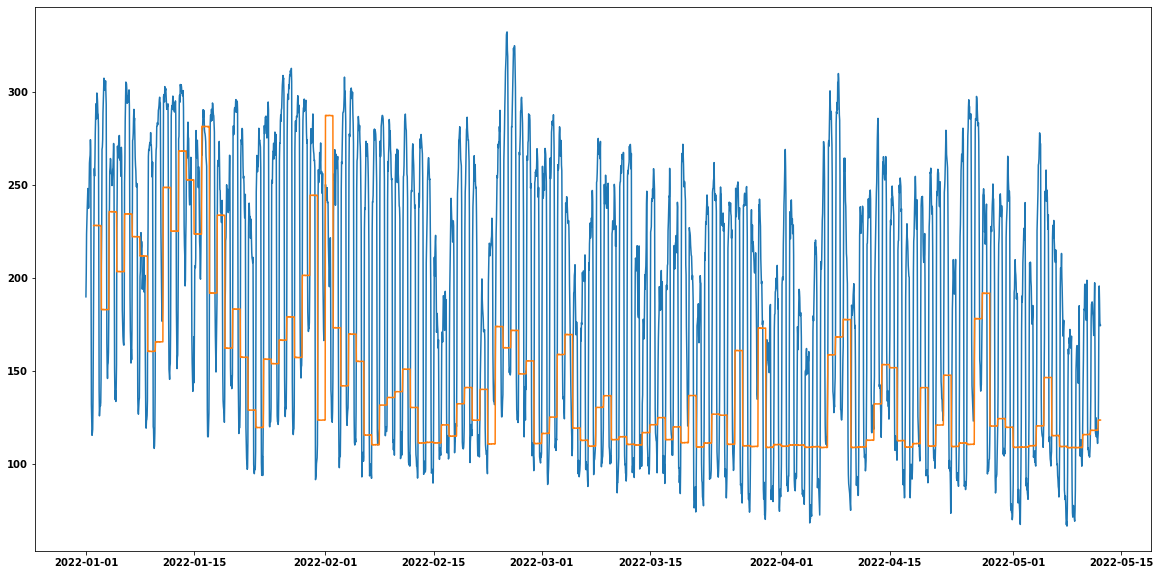

In [195]:
plt.figure(figsize=(20,10))
plt.plot(df_test.datetime, df_test.carbon_per_MWh)
plt.plot(df_test.datetime[24:], preds.ravel()[:len(df_test)-24])

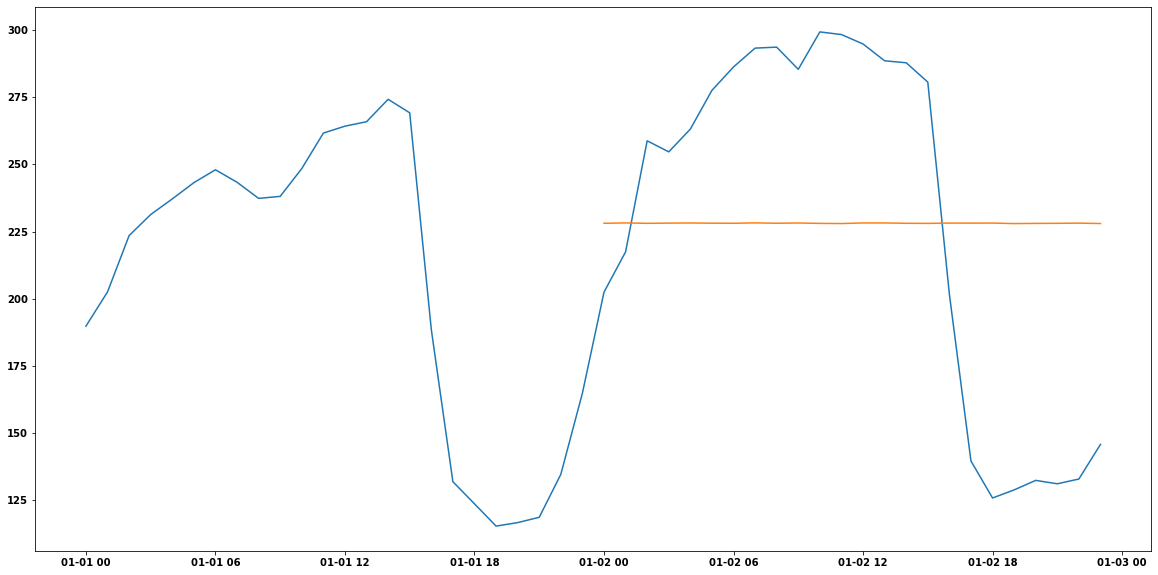

In [200]:
plt.figure(figsize=(20,10))
plt.plot(df_test.datetime[:48], df_test.carbon_per_MWh[:48])
plt.plot(df_test.datetime[24:48], preds.ravel()[:24])

In [203]:
np.abs(df_test.carbon_per_MWh[24:48] - preds.ravel()[:24]).mean()

62.1592942569867

In [208]:
m.predict(test_X[0].reshape(-1,24,5)).ravel()

array([228.07243, 228.20616, 228.05711, 228.13324, 228.186  , 228.1021 ,
       228.08011, 228.22075, 228.08208, 228.17851, 228.03134, 227.97313,
       228.19624, 228.19542, 228.06877, 228.03456, 228.14784, 228.12642,
       228.15157, 227.95885, 228.02693, 228.05928, 228.13165, 227.97469],
      dtype=float32)

In [209]:
df_train.carbon_per_MWh.mean()

243.65882459750114

[(24532, 24, 5), (24532, 24, 1), (6132, 24, 5), (6132, 24, 1)]
Train on 24532 samples, validate on 6132 samples
Epoch 1/50
24532/24532 [==============================] - 60s 2ms/sample - loss: 53774.7294 - mean_absolute_error: 216.7364 - val_loss: 42230.2148 - val_mean_absolute_error: 194.6481
Epoch 2/50
24532/24532 [==============================] - 59s 2ms/sample - loss: 35973.3635 - mean_absolute_error: 171.1279 - val_loss: 27321.0362 - val_mean_absolute_error: 151.6140
Epoch 3/50
24532/24532 [==============================] - 62s 3ms/sample - loss: 23677.4008 - mean_absolute_error: 133.0529 - val_loss: 17143.1275 - val_mean_absolute_error: 115.4138
Epoch 4/50
24532/24532 [==============================] - 62s 3ms/sample - loss: 15531.6388 - mean_absolute_error: 104.8668 - val_loss: 10620.4069 - val_mean_absolute_error: 88.5911
Epoch 5/50
24532/24532 [==============================] - 61s 3ms/sample - loss: 10593.0428 - mean_absolute_error: 86.1196 - val_loss: 6899.0827 - val_mean_a

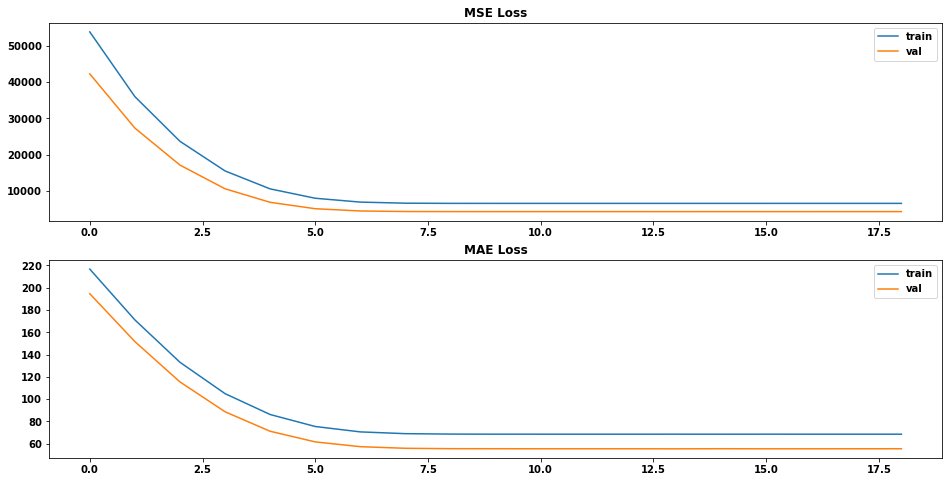

In [192]:
input_len = 24
output_len = 24
layers = [128, 64]
max_epochs = 50
patience = 5

day2day_2 = fit_lstm(input_len=input_len, output_len=output_len, layers=layers, df=df_train, max_epochs=max_epochs, patience=patience)

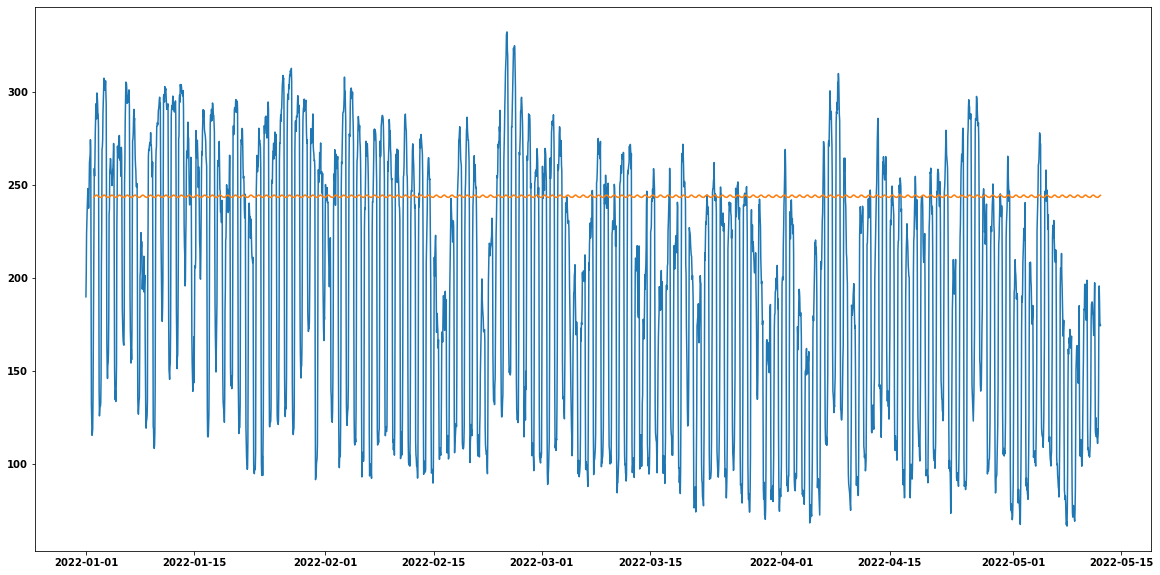

In [197]:
preds_2 = day2day_2["model"].predict(test_X)

plt.figure(figsize=(20,10))
plt.plot(df_test.datetime, df_test.carbon_per_MWh)
plt.plot(df_test.datetime[24:], preds_2.ravel()[:len(df_test)-24])

In [212]:
input_len = 3 * 24
output_len = 24
layers = [32, 16]
max_epochs = 50
patience = 5

day2day_3 = fit_lstm(input_len=input_len, output_len=output_len, layers=layers, df=df_train, max_epochs=max_epochs, patience=patience)

[(24548, 24, 5), (24548, 4, 1), (6136, 24, 5), (6136, 4, 1)]
Train on 24548 samples, validate on 6136 samples
Epoch 1/50
 8416/24548 [=========>....................] - ETA: 17s - loss: 64358.1409 - mean_absolute_error: 240.2155

KeyboardInterrupt: 

In [213]:
def generate_gru_model(layers: List[int], output_len: int):
    
    model = tf.keras.models.Sequential()
    
    for units in layers[:-1]:
        model.add(tf.keras.layers.GRU(units=units, return_sequences=True))
    
    model.add(tf.keras.layers.GRU(units=layers[-1], return_sequences=False))
    
    model.add(tf.keras.layers.Dense(units=output_len*1))
    model.add(tf.keras.layers.Reshape([output_len, 1]))
    
    return model



def fit_gru(input_len: int, output_len: int, layers: List[int],
             df: pd.DataFrame, x_cols: List[str] = ..., y_cols: List[str] = ..., val_ratio: float = 0.2,
             max_epochs: int = 20, patience: int = 2):
    
    if x_cols is Ellipsis:
        x_cols = ["carbon_per_MWh", "day_sin", "day_cos", "year_sin", "year_cos"]
    if y_cols is Ellipsis:
        y_cols = ["carbon_per_MWh"]
    
    gru = generate_gru_model(layers=layers, output_len=output_len)
    (X, y), val_Xy = generate_data(df=df, input_len=input_len, output_len=output_len, x_cols=x_cols, y_cols=y_cols, val_ratio=val_ratio)
    history = compile_and_fit(model=gru, X=X, y=y, val=val_Xy, max_epochs=max_epochs, patience=patience)
    plot_history(history=history)
    
    return_obj = {
        "model": gru,
        "history": history,
        "hp": {
            "input_len": input_len,
            "output_len": output_len,
            "layers": layers,
            "x_cols": x_cols,
            "y_cols": y_cols,
            "val_ratio": val_ratio,
            "max_epochs": max_epochs,
            "patience": patience
        }
    }
    
    return return_obj

[(24493, 72, 5), (24493, 24, 1), (6123, 72, 5), (6123, 24, 1)]
Train on 24493 samples, validate on 6123 samples
Epoch 1/50
24493/24493 [==============================] - 65s 3ms/sample - loss: 62396.8971 - mean_absolute_error: 236.1736 - val_loss: 57820.2649 - val_mean_absolute_error: 231.2619
Epoch 2/50
24493/24493 [==============================] - 65s 3ms/sample - loss: 56397.0317 - mean_absolute_error: 223.1097 - val_loss: 52111.2972 - val_mean_absolute_error: 218.5706
Epoch 3/50
24493/24493 [==============================] - 64s 3ms/sample - loss: 50963.0963 - mean_absolute_error: 210.5757 - val_loss: 46848.1895 - val_mean_absolute_error: 206.1795
Epoch 4/50
24493/24493 [==============================] - 63s 3ms/sample - loss: 45934.9088 - mean_absolute_error: 198.2832 - val_loss: 41962.9331 - val_mean_absolute_error: 193.9710
Epoch 5/50
24493/24493 [==============================] - 63s 3ms/sample - loss: 41268.8674 - mean_absolute_error: 186.1681 - val_loss: 37426.7559 - val_mea

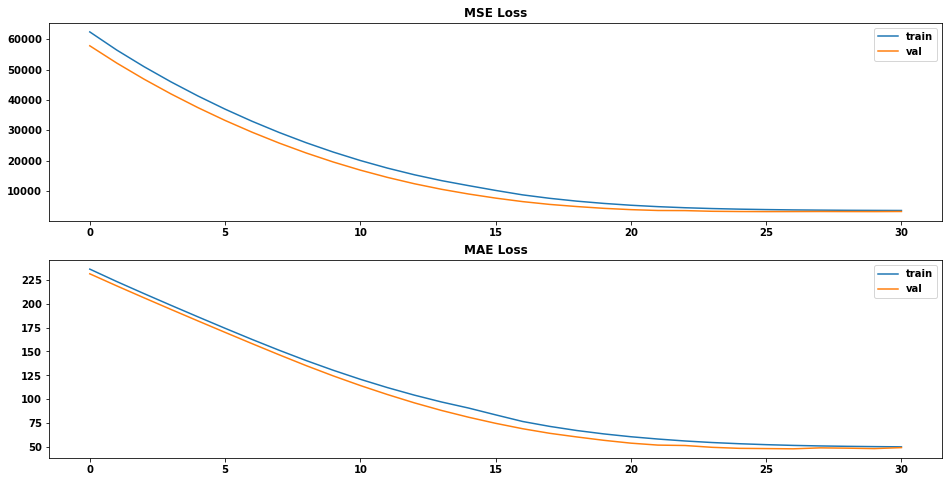

In [216]:
input_len = 3 * 24
output_len = 24
layers = [32, 16]
max_epochs = 50
patience = 5

day2day_4 = fit_gru(input_len=input_len, output_len=output_len, layers=layers, df=df_train, max_epochs=max_epochs, patience=patience)

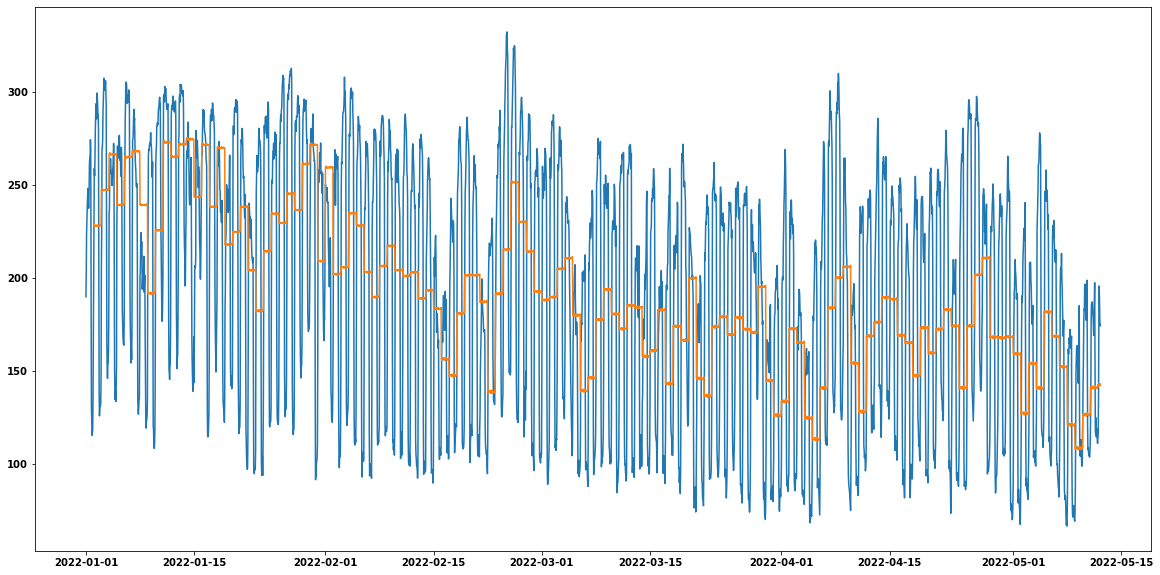

In [217]:
preds_4 = day2day_4["model"].predict(test_X)

plt.figure(figsize=(20,10))
plt.plot(df_test.datetime, df_test.carbon_per_MWh)
plt.plot(df_test.datetime[24:], preds_4.ravel()[:len(df_test)-24])

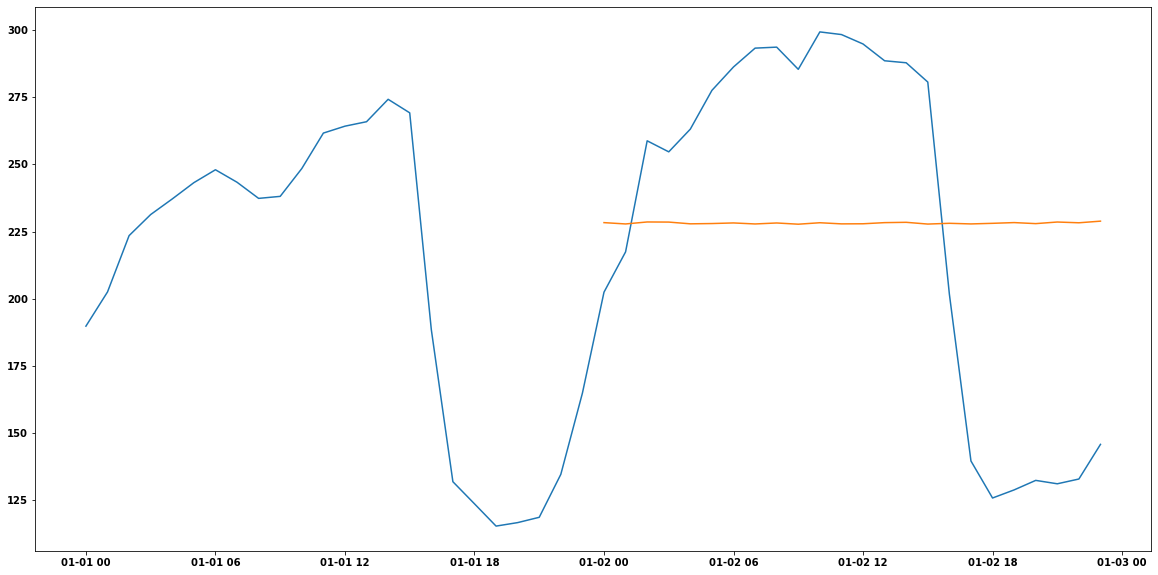

In [218]:
plt.figure(figsize=(20,10))
plt.plot(df_test.datetime[:48], df_test.carbon_per_MWh[:48])
plt.plot(df_test.datetime[24:48], preds_4.ravel()[:24])

Dense

In [221]:
def generate_dense_model(layers: List[int], output_len: int):
    
    model = tf.keras.models.Sequential()
    
    for units in layers:
        model.add(tf.keras.layers.Dense(units=units))
    
    model.add(tf.keras.layers.Dense(units=output_len*1))
    
    return model



def fit_dense(input_len: int, output_len: int, layers: List[int],
             df: pd.DataFrame, x_cols: List[str] = ..., y_cols: List[str] = ..., val_ratio: float = 0.2,
             max_epochs: int = 20, patience: int = 2):
    
    if x_cols is Ellipsis:
        x_cols = ["carbon_per_MWh", "day_sin", "day_cos", "year_sin", "year_cos"]
    if y_cols is Ellipsis:
        y_cols = ["carbon_per_MWh"]
    
    dense = generate_dense_model(layers=layers, output_len=output_len)
    (X, y), (val_X, val_y) = generate_data(df=df, input_len=input_len, output_len=output_len, x_cols=x_cols, y_cols=y_cols, val_ratio=val_ratio)
    X = X.reshape(X.shape[0], -1)
    y = y.reshape(y.shape[0], -1)
    val_X = val_X.reshape(val_X.shape[0], -1)
    val_y = val_y.reshape(val_y.shape[0], -1)
    history = compile_and_fit(model=dense, X=X, y=y, val=(val_X, val_y), max_epochs=max_epochs, patience=patience)
    plot_history(history=history)
    
    return_obj = {
        "model": dense,
        "history": history,
        "hp": {
            "input_len": input_len,
            "output_len": output_len,
            "layers": layers,
            "x_cols": x_cols,
            "y_cols": y_cols,
            "val_ratio": val_ratio,
            "max_epochs": max_epochs,
            "patience": patience
        }
    }
    
    return return_obj

[(24493, 72, 5), (24493, 24, 1), (6123, 72, 5), (6123, 24, 1)]
Train on 24493 samples, validate on 6123 samples
Epoch 1/50
24493/24493 [==============================] - 7s 286us/sample - loss: 1543.3438 - mean_absolute_error: 27.0059 - val_loss: 668.3153 - val_mean_absolute_error: 20.0880
Epoch 2/50
24493/24493 [==============================] - 3s 132us/sample - loss: 842.6766 - mean_absolute_error: 22.2421 - val_loss: 724.8422 - val_mean_absolute_error: 20.7469
Epoch 3/50
24493/24493 [==============================] - 3s 135us/sample - loss: 810.9926 - mean_absolute_error: 21.8034 - val_loss: 608.6199 - val_mean_absolute_error: 18.8326
Epoch 4/50
24493/24493 [==============================] - 3s 133us/sample - loss: 809.4158 - mean_absolute_error: 21.7758 - val_loss: 768.6773 - val_mean_absolute_error: 22.1114
Epoch 5/50
24493/24493 [==============================] - 4s 152us/sample - loss: 791.4936 - mean_absolute_error: 21.4764 - val_loss: 702.1365 - val_mean_absolute_error: 20.38

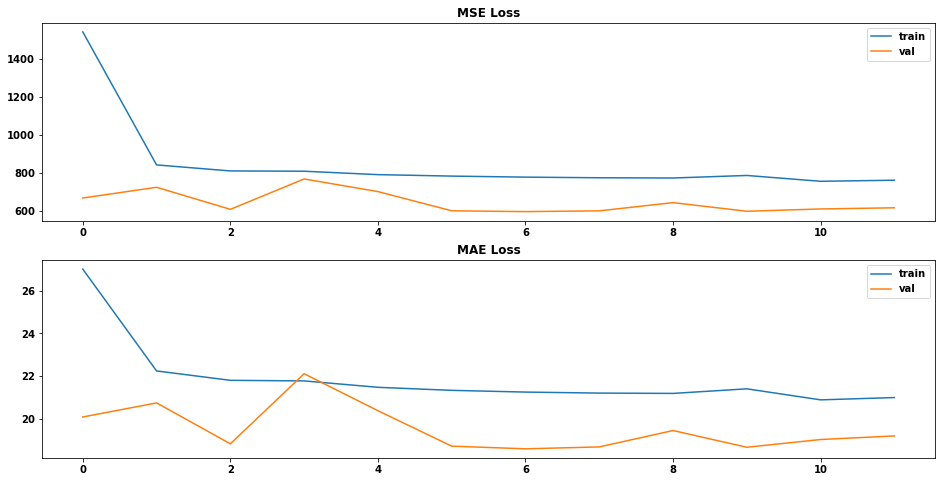

In [222]:
input_len = 3 * 24
output_len = 24
layers = [256, 64]
max_epochs = 50
patience = 5

day2day_4 = fit_dense(input_len=input_len, output_len=output_len, layers=layers, df=df_train, max_epochs=max_epochs, patience=patience)

In [230]:
test_X_dense = df_test.loc[:,day2day_4["hp"]["x_cols"]].to_numpy()[:-(len(df_test)%(24*3))].reshape(-1,24*3,len(day2day["hp"]["x_cols"])).astype(np.float32)
test_X_dense.shape

(43, 72, 5)

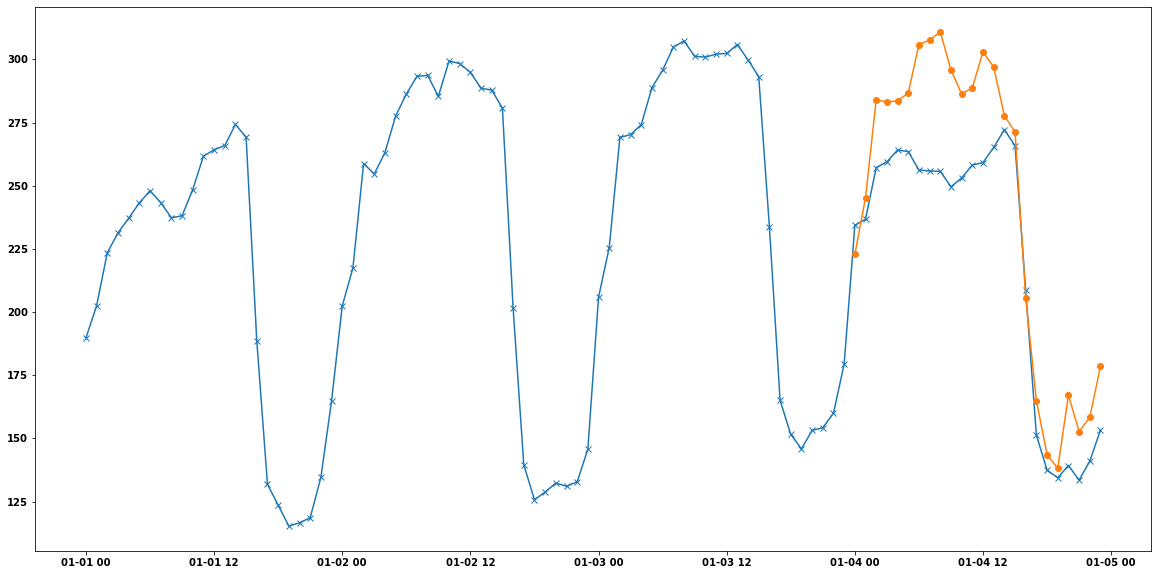

In [239]:
preds = day2day_4["model"].predict(test_X_dense.reshape(test_X_dense.shape[0], -1))[0,...]

plt.figure(figsize=(20,10))
plt.plot(df_test.datetime[:24*4], df_test.carbon_per_MWh[:24*4], 'x-')
plt.plot(df_test.datetime[3*24:4*24], preds.ravel(), 'o-')

[(24532, 24, 5), (24532, 24, 1), (6132, 24, 5), (6132, 24, 1)]
Train on 24532 samples, validate on 6132 samples
Epoch 1/50
24532/24532 [==============================] - 6s 234us/sample - loss: 1529.9237 - mean_absolute_error: 26.4995 - val_loss: 704.2778 - val_mean_absolute_error: 20.5504
Epoch 2/50
24532/24532 [==============================] - 3s 108us/sample - loss: 863.2546 - mean_absolute_error: 22.2795 - val_loss: 636.1318 - val_mean_absolute_error: 19.3632
Epoch 3/50
24532/24532 [==============================] - 3s 121us/sample - loss: 833.9445 - mean_absolute_error: 21.8483 - val_loss: 667.6132 - val_mean_absolute_error: 19.9947
Epoch 4/50
24532/24532 [==============================] - 3s 141us/sample - loss: 835.4509 - mean_absolute_error: 21.8796 - val_loss: 651.6317 - val_mean_absolute_error: 19.6188
Epoch 5/50
24532/24532 [==============================] - 3s 141us/sample - loss: 832.2318 - mean_absolute_error: 21.8339 - val_loss: 626.3938 - val_mean_absolute_error: 19.19

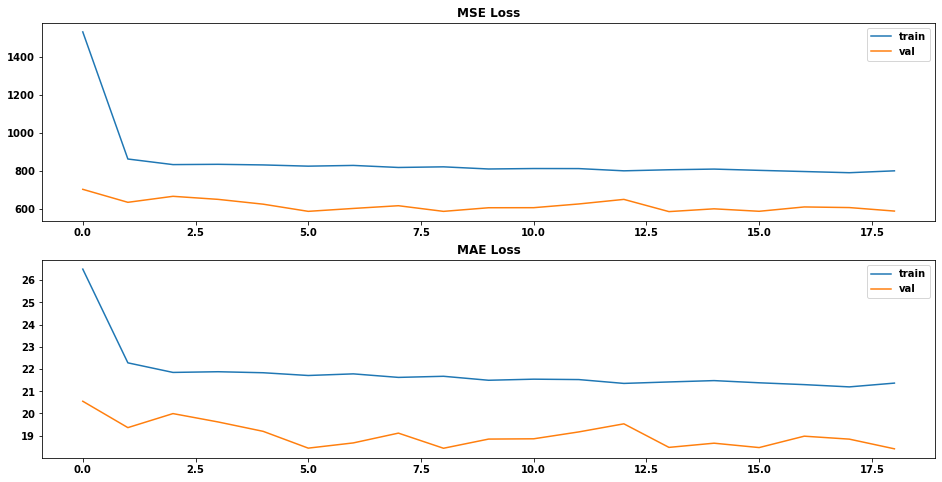

In [241]:
input_len = 24
output_len = 24
layers = [256, 64]
max_epochs = 50
patience = 5

day2day_5 = fit_dense(input_len=input_len, output_len=output_len, layers=layers, df=df_train, max_epochs=max_epochs, patience=patience)

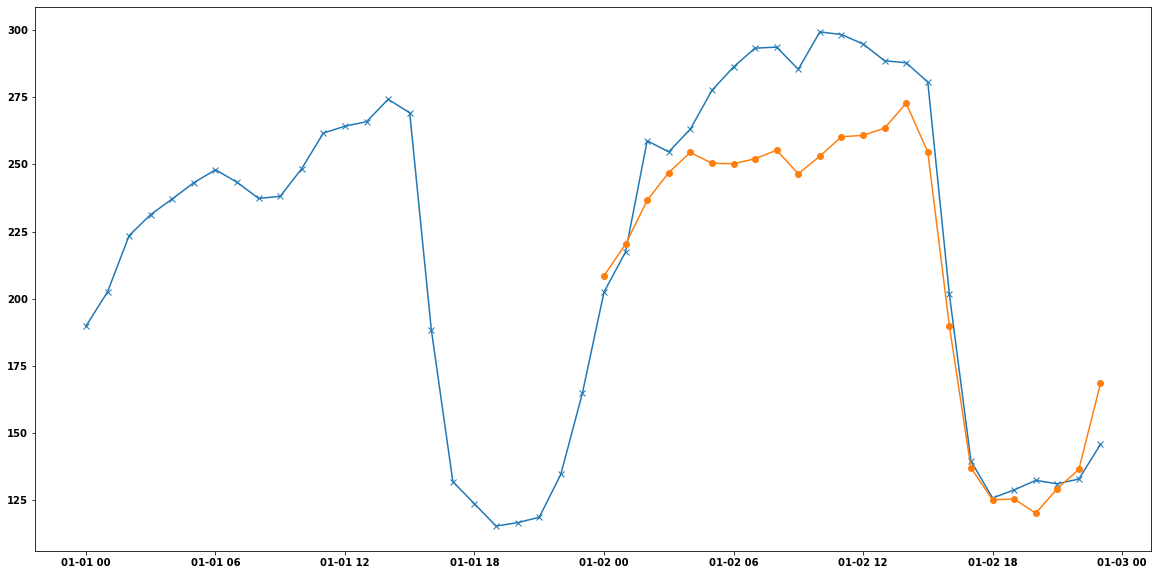

In [243]:
preds = day2day_5["model"].predict(test_X.reshape(test_X.shape[0], -1))[0,...]

plt.figure(figsize=(20,10))
plt.plot(df_test.datetime[:24*2], df_test.carbon_per_MWh[:24*2], 'x-')
plt.plot(df_test.datetime[1*24:2*24], preds.ravel(), 'o-')

[(24416, 168, 5), (24416, 24, 1), (6104, 168, 5), (6104, 24, 1)]
Train on 24416 samples, validate on 6104 samples
Epoch 1/50
24416/24416 [==============================] - 8s 322us/sample - loss: 1659.8778 - mean_absolute_error: 28.6807 - val_loss: 711.4397 - val_mean_absolute_error: 20.8724
Epoch 2/50
24416/24416 [==============================] - 4s 181us/sample - loss: 859.4453 - mean_absolute_error: 22.7287 - val_loss: 605.2819 - val_mean_absolute_error: 19.1398
Epoch 3/50
24416/24416 [==============================] - 4s 182us/sample - loss: 798.9432 - mean_absolute_error: 21.8205 - val_loss: 598.6925 - val_mean_absolute_error: 18.9576
Epoch 4/50
24416/24416 [==============================] - 5s 185us/sample - loss: 787.4462 - mean_absolute_error: 21.6434 - val_loss: 760.5459 - val_mean_absolute_error: 21.9609
Epoch 5/50
24416/24416 [==============================] - 5s 188us/sample - loss: 779.0620 - mean_absolute_error: 21.5040 - val_loss: 1007.0648 - val_mean_absolute_error: 25

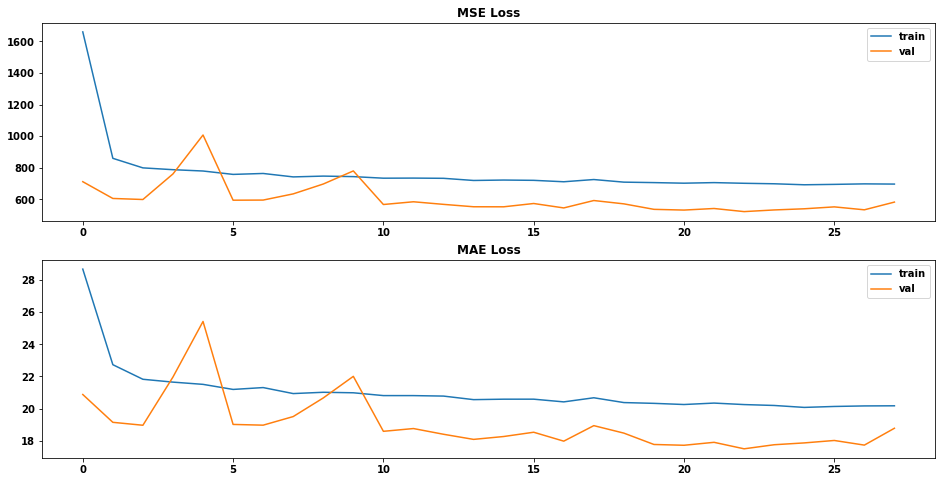

In [244]:
input_len = 7*24
output_len = 24
layers = [256, 64, 32]
max_epochs = 50
patience = 5

week2day = fit_dense(input_len=input_len, output_len=output_len, layers=layers, df=df_train, max_epochs=max_epochs, patience=patience)

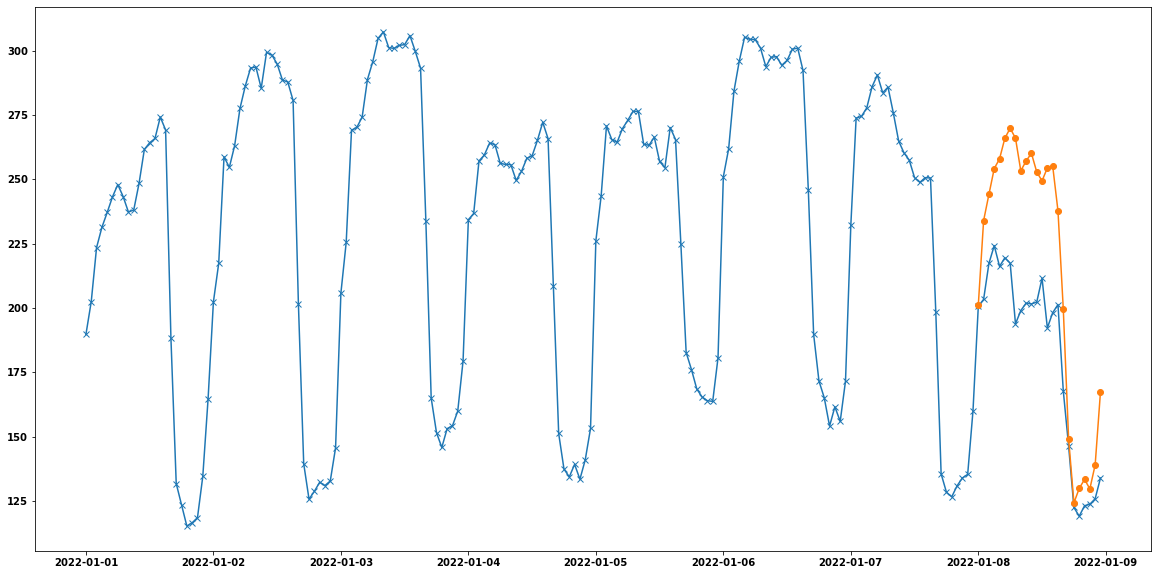

In [246]:
test_X_week = df_test.loc[:,week2day["hp"]["x_cols"]].to_numpy()[:-(len(df_test)%(24*7))].reshape(-1,24*7,len(day2day["hp"]["x_cols"])).astype(np.float32)

preds = week2day["model"].predict(test_X_week.reshape(test_X_week.shape[0], -1))[0,...]

plt.figure(figsize=(20,10))
plt.plot(df_test.datetime[:24*8], df_test.carbon_per_MWh[:24*8], 'x-')
plt.plot(df_test.datetime[7*24:8*24], preds.ravel(), 'o-')

In [4]:
import pickle

In [264]:
pickle.load(open("../data/predictions/state_list.pkl", "rb"))

['Texas',
 'Carolinas',
 'Florida',
 'Southeast',
 'Tennessee',
 'Central',
 'Southwest',
 'Midwest',
 'New-York',
 'Mid-Atlantic',
 'New-England',
 'California',
 'Northwest']

In [265]:
pr = pickle.load(open("../data/predictions/rfpred.pkl", "rb"))

In [269]:
list(pr[0].keys())[0], list(pr[0].keys())[-1]

(Timestamp('2022-01-01 01:00:00+0000', tz='UTC'),
 Timestamp('2022-05-12 05:00:00+0000', tz='UTC'))

In [270]:
type(list(pr[0].keys())[0])

pandas._libs.tslibs.timestamps.Timestamp

In [271]:
pd.Timestamp

pandas._libs.tslibs.timestamps.Timestamp

In [290]:
model = week2day["model"]
hp = week2day["hp"]
input_len = hp["input_len"]
output_len = hp["output_len"]
x_cols = hp["x_cols"]
y_cols = hp["y_cols"]

In [295]:
test_df = df.loc[(df.datetime + dt.timedelta(hours=hp["input_len"])).dt.year >= 2022]

data_X = test_df.loc[:, x_cols].to_numpy()
# data_y = test_df.loc[:, y_cols]

test_X = []

for i in range(input_len, data_X.shape[0], output_len):
    inp = data_X[i-input_len:i, ...].ravel()
    test_X.append(inp)
    
test_X = np.array(test_X)

test_X.shape

(132, 840)

In [304]:
timestamps = df.loc[df.datetime.dt.year >= 2022, "datetime"]

preds = model.predict(test_X).ravel()

In [305]:
{tm: pv for tm, pv in zip(timestamps, preds)}

{Timestamp('2022-01-01 00:00:00+0000', tz='UTC'): 176.83113,
 Timestamp('2022-01-01 01:00:00+0000', tz='UTC'): 195.00037,
 Timestamp('2022-01-01 02:00:00+0000', tz='UTC'): 200.78525,
 Timestamp('2022-01-01 03:00:00+0000', tz='UTC'): 213.2215,
 Timestamp('2022-01-01 04:00:00+0000', tz='UTC'): 223.56642,
 Timestamp('2022-01-01 05:00:00+0000', tz='UTC'): 235.22006,
 Timestamp('2022-01-01 06:00:00+0000', tz='UTC'): 241.09038,
 Timestamp('2022-01-01 07:00:00+0000', tz='UTC'): 240.44707,
 Timestamp('2022-01-01 08:00:00+0000', tz='UTC'): 231.46529,
 Timestamp('2022-01-01 09:00:00+0000', tz='UTC'): 230.94424,
 Timestamp('2022-01-01 10:00:00+0000', tz='UTC'): 228.79811,
 Timestamp('2022-01-01 11:00:00+0000', tz='UTC'): 222.80933,
 Timestamp('2022-01-01 12:00:00+0000', tz='UTC'): 218.60214,
 Timestamp('2022-01-01 13:00:00+0000', tz='UTC'): 214.39545,
 Timestamp('2022-01-01 14:00:00+0000', tz='UTC'): 210.91057,
 Timestamp('2022-01-01 15:00:00+0000', tz='UTC'): 202.16707,
 Timestamp('2022-01-01 16

# Generating predictions

In [5]:
import os
import sys
import pickle


def project_dir():
    notebook_path = %pwd
    repo_name = "sisi"
    repo_folder = notebook_path.split(repo_name)[0]
    return os.path.join(repo_folder, repo_name)


pwd = os.getenv("PWD", project_dir())
os.environ["PWD"] = pwd
sys.path.append(pwd)

In [6]:
from Utils.data_utils import get_data_and_state_list

In [7]:
def generate_dense_model(layers: List[int], output_len: int):
    
    model = tf.keras.models.Sequential()
    
    for units in layers:
        model.add(tf.keras.layers.Dense(units=units))
    
    model.add(tf.keras.layers.Dense(units=output_len*1))
    
    return model



def generate_data(df: pd.DataFrame, input_len: int, output_len: int, x_cols: List[str], y_cols: List[str], val_ratio: float):
    
    data_X = df.loc[:, x_cols].to_numpy().reshape(-1, len(x_cols))
    data_y = df.loc[:, y_cols].to_numpy().reshape(-1, len(y_cols))
    
    # maybe later :)
    # data_X = (data_X - data_X.mean(axis=0)) / data_X.std(axis=0)
    # data_y = (data_y - data_y.mean(axis=0)) / data_y.std(axis=0)
    
    X = []
    y = []

    for i in range(input_len, data_X.shape[0]-output_len):
        inp = data_X[i-input_len:i, :]
        out = data_y[i:i+output_len, :]
        X.append(inp)
        y.append(out)

    X = np.array(X).reshape(-1, input_len, len(x_cols))
    y = np.array(y).reshape(-1, output_len, len(y_cols))
    
    val_len = int(val_ratio * X.shape[0])
    train_X = X[:-val_len, ...]
    train_y = y[:-val_len, ...]
    val_X = X[-val_len:, ...]
    val_y = y[-val_len:, ...]
    
    return (train_X, train_y), (val_X, val_y)



def plot_history(history: tf.keras.callbacks.History):
    f, ax = plt.subplots(2, 1, figsize=(16,8))
    ax[0].plot(history.history["loss"], label="train")
    ax[0].plot(history.history["val_loss"], label="val")
    ax[0].set_title("MSE Loss")
    ax[0].legend()
    ax[1].plot(history.history["mean_absolute_error"], label="train")
    ax[1].plot(history.history["val_mean_absolute_error"], label="val")
    ax[1].set_title("MAE Loss")
    ax[1].legend()
    plt.show()



def compile_and_fit(model: tf.keras.Model, X: np.ndarray, y: np.ndarray, val: Tuple[np.ndarray], max_epochs: int = 20, patience: int = 2, verbose: int = 0):

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)
    model.compile(loss="mse", optimizer="adam", metrics=["mae"])
    history = model.fit(X, y, epochs=max_epochs, batch_size=4, validation_data=val, callbacks=[early_stopping], verbose=verbose)
    
    return history



def fit_dense(input_len: int, output_len: int, layers: List[int],
             df: pd.DataFrame, x_cols: List[str] = ..., y_cols: List[str] = ..., val_ratio: float = 0.2,
             max_epochs: int = 20, patience: int = 2, verbose: int = 0):
    
    if x_cols is Ellipsis:
        x_cols = ["carbon_per_MWh", "day_sin", "day_cos", "year_sin", "year_cos"]
    if y_cols is Ellipsis:
        y_cols = ["carbon_per_MWh"]
    
    dense = generate_dense_model(layers=layers, output_len=output_len)
    
    (X, y), (val_X, val_y) = generate_data(df=df, input_len=input_len, output_len=output_len, x_cols=x_cols, y_cols=y_cols, val_ratio=val_ratio)
    X = X.reshape(X.shape[0], -1)
    y = y.reshape(y.shape[0], -1)
    val_X = val_X.reshape(val_X.shape[0], -1)
    val_y = val_y.reshape(val_y.shape[0], -1)
    print([a.shape for a in (X, y, val_X, val_y)])

    history = compile_and_fit(model=dense, X=X, y=y, val=(val_X, val_y), max_epochs=max_epochs, patience=patience, verbose=verbose)
    plot_history(history=history)
    
    return_obj = {
        "model": dense,
        "history": history,
        "hp": {
            "input_len": input_len,
            "output_len": output_len,
            "layers": layers,
            "x_cols": x_cols,
            "y_cols": y_cols,
            "val_ratio": val_ratio,
            "max_epochs": max_epochs,
            "patience": patience
        }
    }
    
    return return_obj

In [11]:
df_list, state_list = get_data_and_state_list(pwd="..")



==== California ====
[(24416, 840), (24416, 24), (6104, 840), (6104, 24)]
Train on 24416 samples, validate on 6104 samples
Epoch 1/50
24416/24416 [==============================] - 10s 419us/sample - loss: 1277.8069 - mean_absolute_error: 27.1521 - val_loss: 1016.7071 - val_mean_absolute_error: 25.3975
Epoch 2/50
24416/24416 [==============================] - 10s 415us/sample - loss: 946.1422 - mean_absolute_error: 23.9442 - val_loss: 641.5162 - val_mean_absolute_error: 19.8598
Epoch 3/50
24416/24416 [==============================] - 11s 438us/sample - loss: 881.9871 - mean_absolute_error: 23.0678 - val_loss: 667.1086 - val_mean_absolute_error: 20.1827
Epoch 4/50
24416/24416 [==============================] - 11s 432us/sample - loss: 839.9086 - mean_absolute_error: 22.4547 - val_loss: 777.5909 - val_mean_absolute_error: 21.8057
Epoch 5/50
24416/24416 [==============================] - 10s 422us/sample - loss: 816.6932 - mean_absolute_error: 22.1080 - val_loss: 637.4806 - val_mean_ab

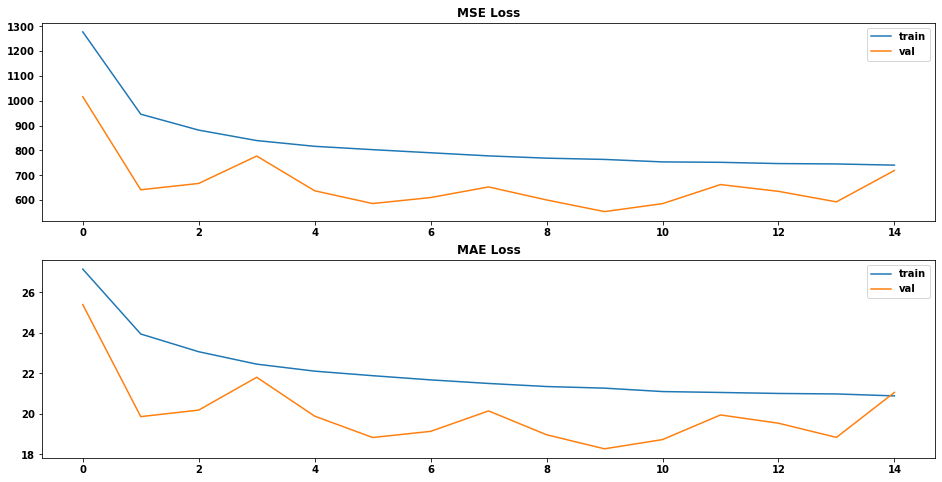



==== Carolinas ====
[(24419, 840), (24419, 24), (6104, 840), (6104, 24)]
Train on 24419 samples, validate on 6104 samples
Epoch 1/50
24419/24419 [==============================] - 10s 406us/sample - loss: 1273.8641 - mean_absolute_error: 26.6041 - val_loss: 1025.9934 - val_mean_absolute_error: 24.9497
Epoch 2/50
24419/24419 [==============================] - 10s 401us/sample - loss: 878.4007 - mean_absolute_error: 22.9135 - val_loss: 723.9772 - val_mean_absolute_error: 20.5576
Epoch 3/50
24419/24419 [==============================] - 10s 393us/sample - loss: 828.8780 - mean_absolute_error: 22.1531 - val_loss: 824.0361 - val_mean_absolute_error: 21.7991
Epoch 4/50
24419/24419 [==============================] - 10s 397us/sample - loss: 803.6737 - mean_absolute_error: 21.7840 - val_loss: 968.9856 - val_mean_absolute_error: 24.8373
Epoch 5/50
24419/24419 [==============================] - 10s 401us/sample - loss: 785.9183 - mean_absolute_error: 21.5013 - val_loss: 863.3182 - val_mean_abs

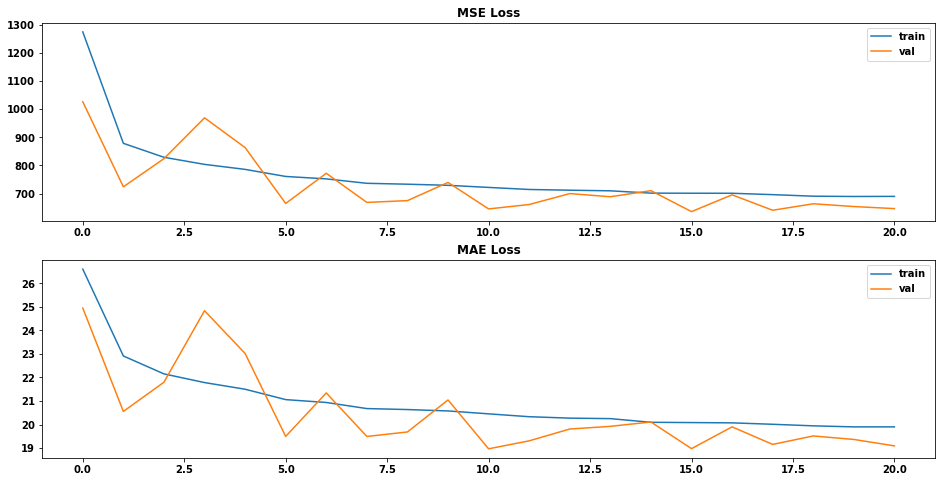



==== Central ====
[(24418, 840), (24418, 24), (6104, 840), (6104, 24)]
Train on 24418 samples, validate on 6104 samples
Epoch 1/50
24418/24418 [==============================] - 10s 420us/sample - loss: 8678.3901 - mean_absolute_error: 71.2132 - val_loss: 8819.5176 - val_mean_absolute_error: 73.3738
Epoch 2/50
24418/24418 [==============================] - 10s 413us/sample - loss: 7253.5948 - mean_absolute_error: 65.5529 - val_loss: 9114.9537 - val_mean_absolute_error: 75.8057
Epoch 3/50
24418/24418 [==============================] - 10s 405us/sample - loss: 6993.7620 - mean_absolute_error: 64.1641 - val_loss: 8300.2802 - val_mean_absolute_error: 70.8320
Epoch 4/50
24418/24418 [==============================] - 10s 412us/sample - loss: 6804.9860 - mean_absolute_error: 63.0148 - val_loss: 9019.5129 - val_mean_absolute_error: 74.5347
Epoch 5/50
24418/24418 [==============================] - 10s 417us/sample - loss: 6707.0051 - mean_absolute_error: 62.4390 - val_loss: 8278.8119 - val_me

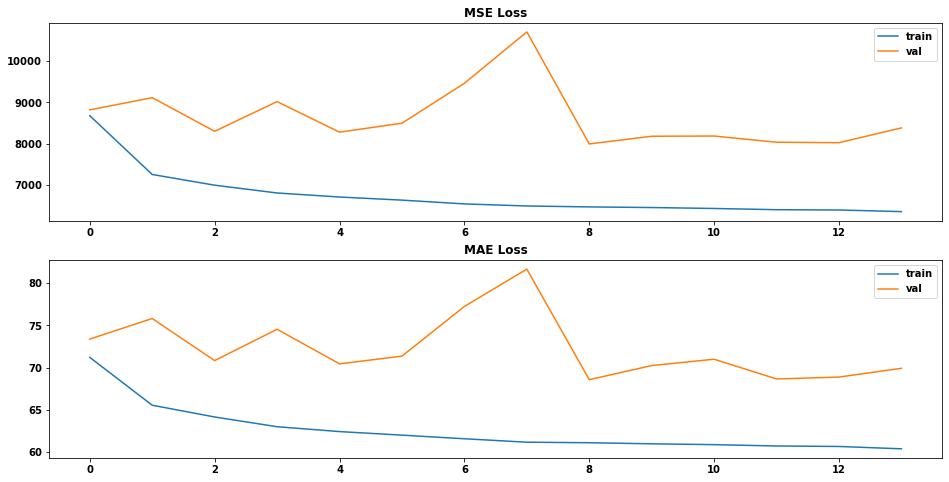



==== Florida ====
[(24400, 840), (24400, 24), (6099, 840), (6099, 24)]
Train on 24400 samples, validate on 6099 samples
Epoch 1/50
24400/24400 [==============================] - 10s 425us/sample - loss: 536.5983 - mean_absolute_error: 15.2119 - val_loss: 249.9980 - val_mean_absolute_error: 12.3126
Epoch 2/50
24400/24400 [==============================] - 10s 427us/sample - loss: 232.9028 - mean_absolute_error: 11.8470 - val_loss: 174.4686 - val_mean_absolute_error: 9.9961
Epoch 3/50
24400/24400 [==============================] - 10s 425us/sample - loss: 205.5332 - mean_absolute_error: 11.0761 - val_loss: 185.6661 - val_mean_absolute_error: 10.3593
Epoch 4/50
24400/24400 [==============================] - 10s 429us/sample - loss: 188.7997 - mean_absolute_error: 10.5745 - val_loss: 255.1642 - val_mean_absolute_error: 12.4342
Epoch 5/50
24400/24400 [==============================] - 10s 426us/sample - loss: 178.7843 - mean_absolute_error: 10.2646 - val_loss: 161.5527 - val_mean_absolute

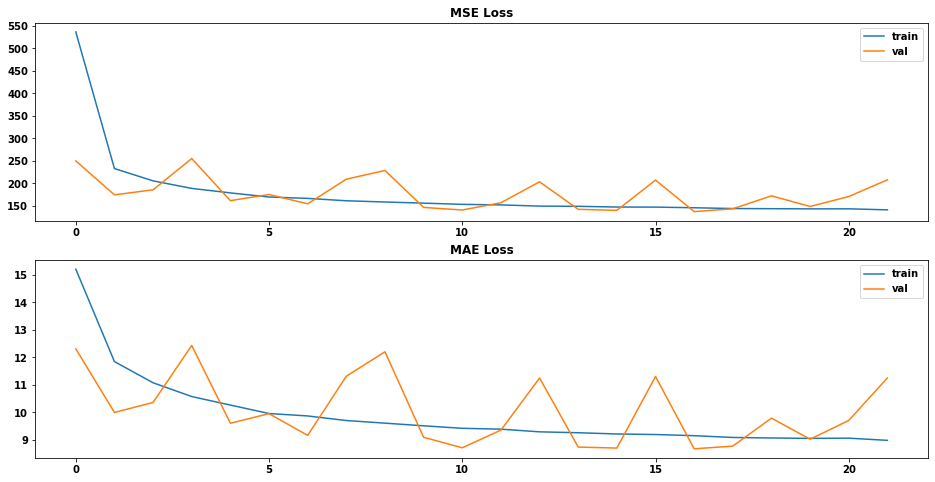



==== Mid-Atlantic ====
[(23004, 840), (23004, 24), (5751, 840), (5751, 24)]
Train on 23004 samples, validate on 5751 samples
Epoch 1/50
23004/23004 [==============================] - 11s 467us/sample - loss: 1014.3645 - mean_absolute_error: 23.6252 - val_loss: 554.7225 - val_mean_absolute_error: 18.5065
Epoch 2/50
23004/23004 [==============================] - 10s 436us/sample - loss: 628.4070 - mean_absolute_error: 19.7811 - val_loss: 515.2450 - val_mean_absolute_error: 18.1582
Epoch 3/50
23004/23004 [==============================] - 10s 433us/sample - loss: 563.8900 - mean_absolute_error: 18.6548 - val_loss: 369.6843 - val_mean_absolute_error: 15.0430
Epoch 4/50
23004/23004 [==============================] - 10s 432us/sample - loss: 534.9276 - mean_absolute_error: 18.1677 - val_loss: 401.1809 - val_mean_absolute_error: 15.5237
Epoch 5/50
23004/23004 [==============================] - 10s 431us/sample - loss: 519.5422 - mean_absolute_error: 17.8778 - val_loss: 375.2542 - val_mean_a

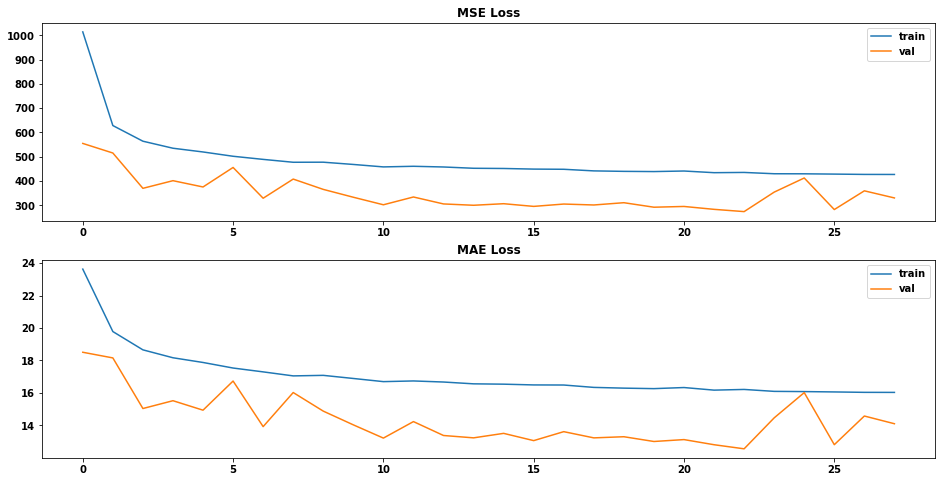



==== Midwest ====
[(24418, 840), (24418, 24), (6104, 840), (6104, 24)]
Train on 24418 samples, validate on 6104 samples
Epoch 1/50
24418/24418 [==============================] - 13s 541us/sample - loss: 2586.7396 - mean_absolute_error: 37.8593 - val_loss: 1479.6300 - val_mean_absolute_error: 31.0700
Epoch 2/50
24418/24418 [==============================] - 13s 541us/sample - loss: 1706.8021 - mean_absolute_error: 32.9521 - val_loss: 1498.1652 - val_mean_absolute_error: 30.7415
Epoch 3/50
24418/24418 [==============================] - 13s 550us/sample - loss: 1584.0538 - mean_absolute_error: 31.6632 - val_loss: 1731.9566 - val_mean_absolute_error: 34.3438
Epoch 4/50
24418/24418 [==============================] - 14s 573us/sample - loss: 1492.8937 - mean_absolute_error: 30.6705 - val_loss: 1440.6759 - val_mean_absolute_error: 29.9930
Epoch 5/50
24418/24418 [==============================] - 13s 552us/sample - loss: 1465.8280 - mean_absolute_error: 30.3483 - val_loss: 1215.8428 - val_me

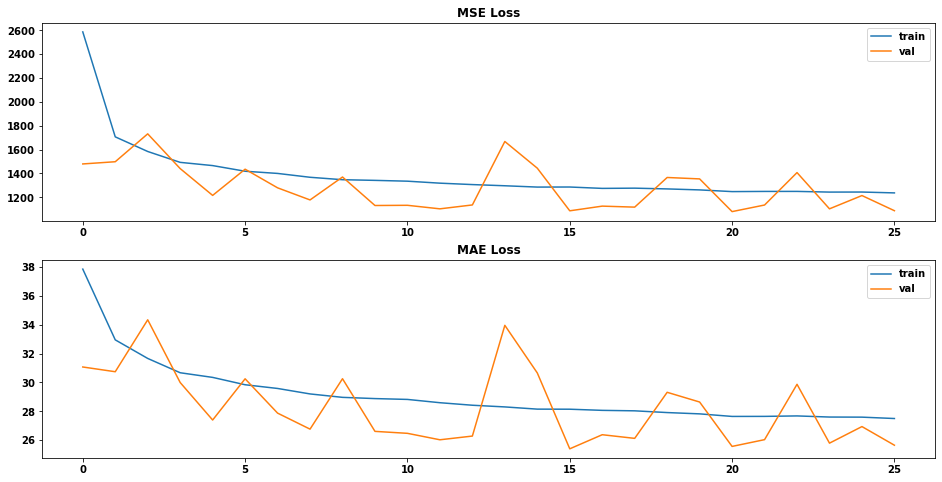



==== New-England ====
[(24419, 840), (24419, 24), (6104, 840), (6104, 24)]
Train on 24419 samples, validate on 6104 samples
Epoch 1/50
24419/24419 [==============================] - 13s 552us/sample - loss: 739.7822 - mean_absolute_error: 20.7489 - val_loss: 570.2745 - val_mean_absolute_error: 18.2473
Epoch 2/50
24419/24419 [==============================] - 13s 547us/sample - loss: 564.1771 - mean_absolute_error: 18.5619 - val_loss: 576.6373 - val_mean_absolute_error: 18.2051
Epoch 3/50
24419/24419 [==============================] - 13s 549us/sample - loss: 516.3135 - mean_absolute_error: 17.6833 - val_loss: 433.3232 - val_mean_absolute_error: 15.8847
Epoch 4/50
24419/24419 [==============================] - 14s 555us/sample - loss: 500.7297 - mean_absolute_error: 17.3672 - val_loss: 427.7477 - val_mean_absolute_error: 15.9373
Epoch 5/50
24419/24419 [==============================] - 14s 553us/sample - loss: 486.6842 - mean_absolute_error: 17.0972 - val_loss: 462.9664 - val_mean_abs

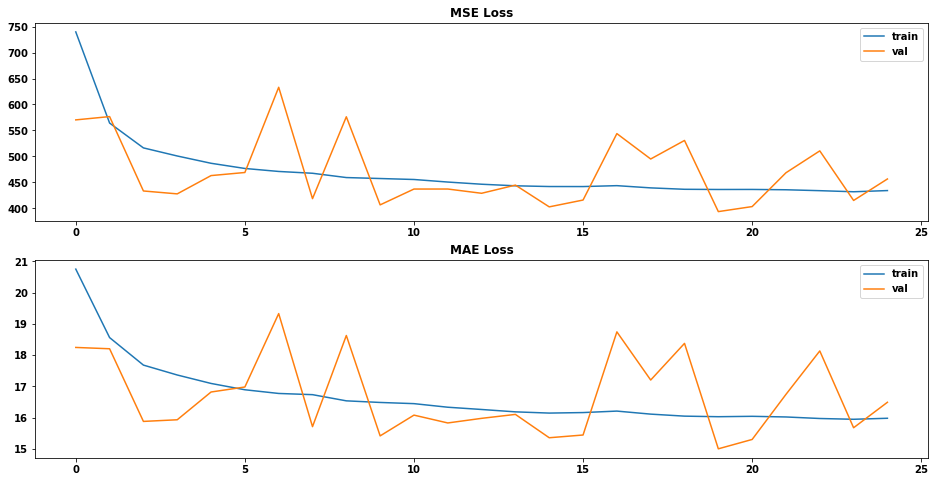



==== New-York ====
[(24409, 840), (24409, 24), (6102, 840), (6102, 24)]
Train on 24409 samples, validate on 6102 samples
Epoch 1/50
24409/24409 [==============================] - 14s 583us/sample - loss: 686.0251 - mean_absolute_error: 19.7195 - val_loss: 639.9975 - val_mean_absolute_error: 20.6842
Epoch 2/50
24409/24409 [==============================] - 13s 529us/sample - loss: 531.3065 - mean_absolute_error: 17.5334 - val_loss: 583.7326 - val_mean_absolute_error: 18.9449
Epoch 3/50
24409/24409 [==============================] - 13s 528us/sample - loss: 501.4487 - mean_absolute_error: 16.9749 - val_loss: 369.6196 - val_mean_absolute_error: 14.7768
Epoch 4/50
24409/24409 [==============================] - 13s 543us/sample - loss: 488.5043 - mean_absolute_error: 16.6632 - val_loss: 354.3651 - val_mean_absolute_error: 14.4993
Epoch 5/50
24409/24409 [==============================] - 13s 529us/sample - loss: 473.0603 - mean_absolute_error: 16.3246 - val_loss: 514.7464 - val_mean_absolu

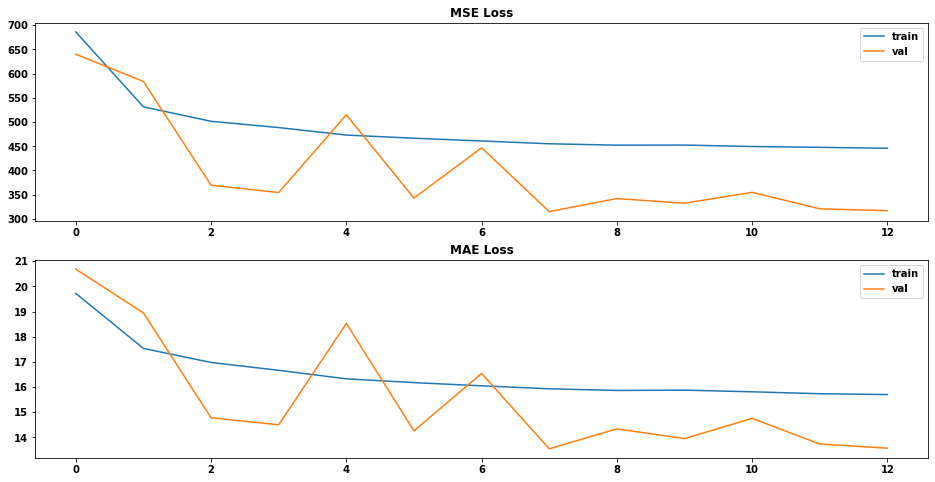



==== Northwest ====
[(24416, 840), (24416, 24), (6104, 840), (6104, 24)]
Train on 24416 samples, validate on 6104 samples
Epoch 1/50
24416/24416 [==============================] - 15s 604us/sample - loss: 1214.3146 - mean_absolute_error: 26.0000 - val_loss: 1252.7996 - val_mean_absolute_error: 28.1981
Epoch 2/50
24416/24416 [==============================] - 15s 600us/sample - loss: 810.4829 - mean_absolute_error: 22.4834 - val_loss: 796.7909 - val_mean_absolute_error: 21.9966
Epoch 3/50
24416/24416 [==============================] - 15s 596us/sample - loss: 745.6624 - mean_absolute_error: 21.5171 - val_loss: 770.2456 - val_mean_absolute_error: 21.6082
Epoch 4/50
24416/24416 [==============================] - 15s 598us/sample - loss: 724.6162 - mean_absolute_error: 21.1623 - val_loss: 926.8338 - val_mean_absolute_error: 23.4358
Epoch 5/50
24416/24416 [==============================] - 15s 600us/sample - loss: 703.4409 - mean_absolute_error: 20.8573 - val_loss: 842.7223 - val_mean_abs

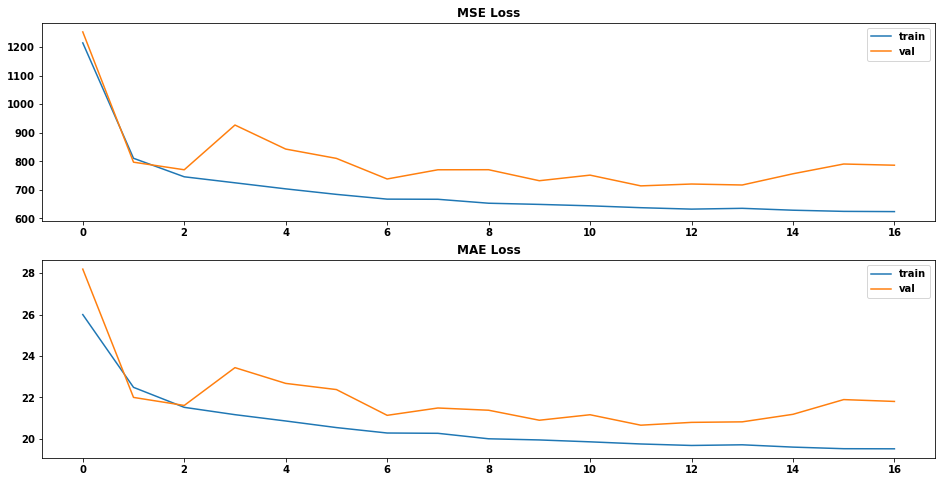



==== Southeast ====
[(24359, 840), (24359, 24), (6089, 840), (6089, 24)]
Train on 24359 samples, validate on 6089 samples
Epoch 1/50
24359/24359 [==============================] - 15s 622us/sample - loss: 1132.4828 - mean_absolute_error: 22.3883 - val_loss: 376.5939 - val_mean_absolute_error: 15.2261
Epoch 2/50
24359/24359 [==============================] - 15s 612us/sample - loss: 714.3859 - mean_absolute_error: 18.3000 - val_loss: 292.1845 - val_mean_absolute_error: 13.5500
Epoch 3/50
24359/24359 [==============================] - 15s 634us/sample - loss: 649.8846 - mean_absolute_error: 17.2914 - val_loss: 970.2469 - val_mean_absolute_error: 26.6547
Epoch 4/50
24359/24359 [==============================] - 15s 616us/sample - loss: 623.4291 - mean_absolute_error: 16.9048 - val_loss: 353.7467 - val_mean_absolute_error: 15.1344
Epoch 5/50
24359/24359 [==============================] - 15s 603us/sample - loss: 594.4242 - mean_absolute_error: 16.4036 - val_loss: 376.1727 - val_mean_abso

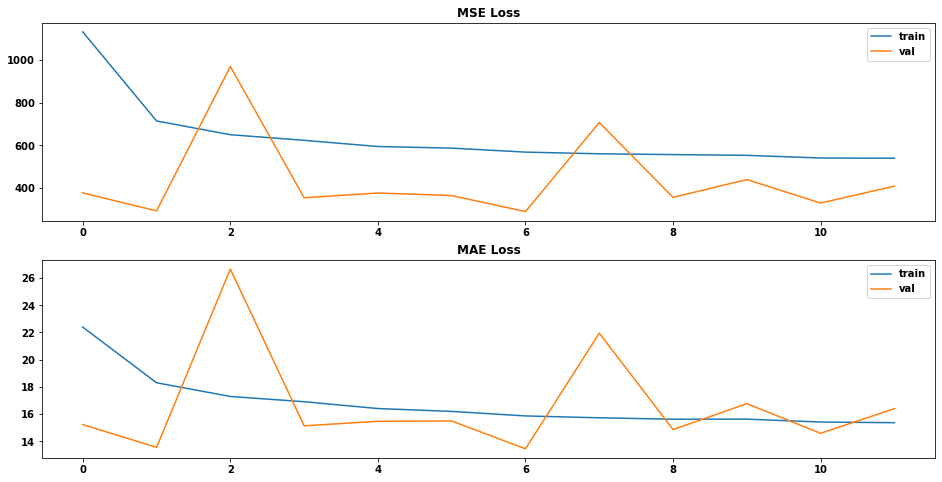



==== Southwest ====
[(24416, 840), (24416, 24), (6104, 840), (6104, 24)]
Train on 24416 samples, validate on 6104 samples
Epoch 1/50
24416/24416 [==============================] - 16s 643us/sample - loss: 785.7127 - mean_absolute_error: 20.0665 - val_loss: 385.3717 - val_mean_absolute_error: 15.3317
Epoch 2/50
24416/24416 [==============================] - 15s 623us/sample - loss: 481.1025 - mean_absolute_error: 16.7628 - val_loss: 525.9316 - val_mean_absolute_error: 18.4211
Epoch 3/50
24416/24416 [==============================] - 15s 628us/sample - loss: 431.6793 - mean_absolute_error: 15.7824 - val_loss: 562.9456 - val_mean_absolute_error: 19.2490
Epoch 4/50
24416/24416 [==============================] - 14s 561us/sample - loss: 402.8728 - mean_absolute_error: 15.1811 - val_loss: 331.3607 - val_mean_absolute_error: 13.9772
Epoch 5/50
24416/24416 [==============================] - 13s 548us/sample - loss: 391.5017 - mean_absolute_error: 14.9269 - val_loss: 376.1718 - val_mean_absol

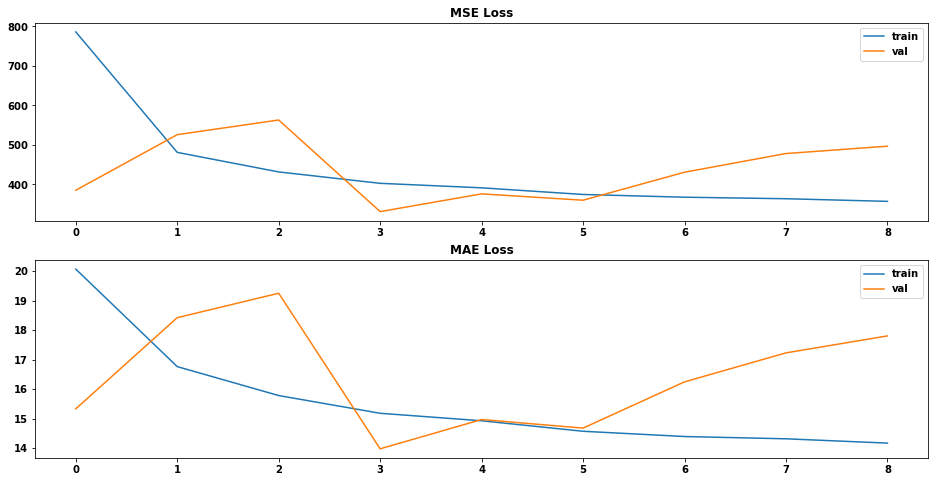



==== Tennessee ====
[(24001, 840), (24001, 24), (6000, 840), (6000, 24)]
Train on 24001 samples, validate on 6000 samples
Epoch 1/50
24001/24001 [==============================] - 14s 575us/sample - loss: 1039.0955 - mean_absolute_error: 24.4879 - val_loss: 1728.8311 - val_mean_absolute_error: 34.9164
Epoch 2/50
24001/24001 [==============================] - 13s 552us/sample - loss: 756.1386 - mean_absolute_error: 21.4413 - val_loss: 520.0476 - val_mean_absolute_error: 17.4754
Epoch 3/50
24001/24001 [==============================] - 14s 569us/sample - loss: 688.9641 - mean_absolute_error: 20.4309 - val_loss: 531.2573 - val_mean_absolute_error: 17.6935
Epoch 4/50
24001/24001 [==============================] - 13s 559us/sample - loss: 663.0531 - mean_absolute_error: 19.9990 - val_loss: 549.9224 - val_mean_absolute_error: 18.0589
Epoch 5/50
24001/24001 [==============================] - 14s 563us/sample - loss: 641.5838 - mean_absolute_error: 19.6123 - val_loss: 488.7281 - val_mean_abs

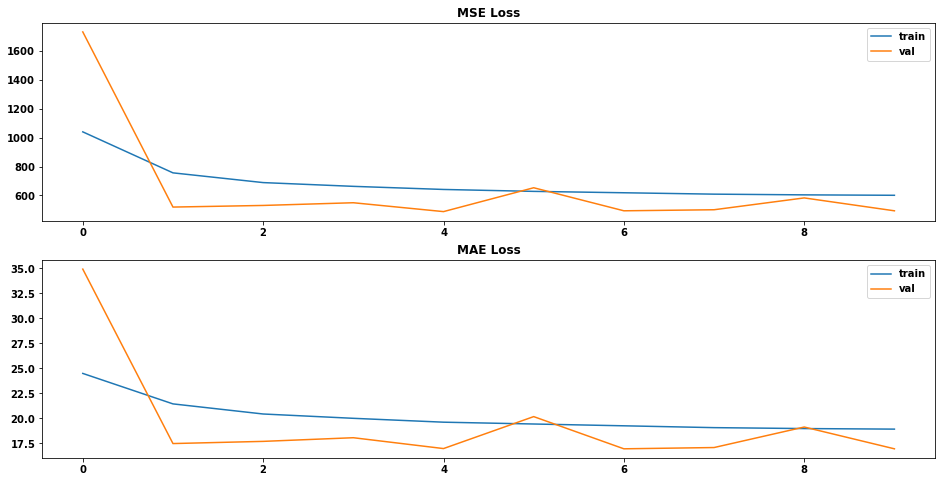



==== Texas ====
[(24361, 840), (24361, 24), (6090, 840), (6090, 24)]
Train on 24361 samples, validate on 6090 samples
Epoch 1/50
24361/24361 [==============================] - 15s 596us/sample - loss: 4620.1853 - mean_absolute_error: 52.5969 - val_loss: 3032.7995 - val_mean_absolute_error: 43.4346
Epoch 2/50
24361/24361 [==============================] - 14s 587us/sample - loss: 3702.5431 - mean_absolute_error: 47.9013 - val_loss: 2913.4321 - val_mean_absolute_error: 42.3069
Epoch 3/50
24361/24361 [==============================] - 14s 586us/sample - loss: 3527.1906 - mean_absolute_error: 46.5305 - val_loss: 2945.1260 - val_mean_absolute_error: 42.2841
Epoch 4/50
24361/24361 [==============================] - 14s 567us/sample - loss: 3411.5480 - mean_absolute_error: 45.5992 - val_loss: 2845.2254 - val_mean_absolute_error: 41.4056
Epoch 5/50
24361/24361 [==============================] - 14s 578us/sample - loss: 3366.8457 - mean_absolute_error: 45.1970 - val_loss: 2776.8173 - val_mean

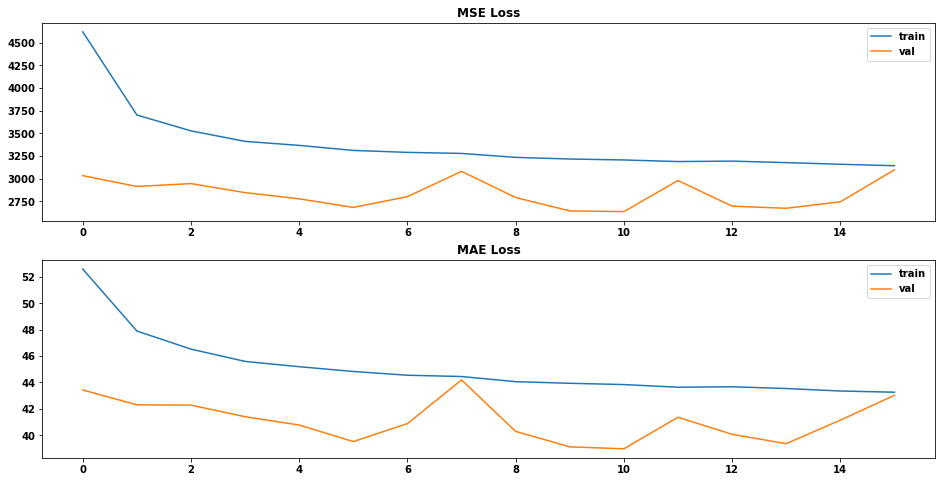

In [12]:
# settings

day_hours = 24 * 60 * 60
year_hours = 365.2425 * day_hours

input_len = 7 * 24
output_len = 24
layers = [256, 64, 32]
max_epochs = 50
patience = 5


# getting predictions

preds_list = []

for df, state in zip(df_list, state_list):
    
    print(f"\n\n==== {state} ====")
    
    # dataframe preparation
    
    df.datetime = pd.to_datetime(df.datetime)
    timestamp_s = df.datetime.map(dt.datetime.timestamp)

    df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day_hours))
    df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day_hours))
    df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year_hours))
    df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year_hours))

    df = df.fillna(value=0)

    df_train = df.loc[df.datetime.dt.year < 2022]


    # training model

    week2day = fit_dense(input_len=input_len, output_len=output_len, layers=layers, df=df_train, max_epochs=max_epochs, patience=patience, verbose=1)


    # generating predictions
    
    model = week2day["model"]
    hp = week2day["hp"]
    input_len = hp["input_len"]
    output_len = hp["output_len"]
    x_cols = hp["x_cols"]
    y_cols = hp["y_cols"]

    df_test = df.loc[(df.datetime + dt.timedelta(hours=hp["input_len"])).dt.year >= 2022]
    data_X = df_test.loc[:, x_cols].to_numpy()

    test_X = []
    for i in range(input_len, data_X.shape[0], output_len):
        inp = data_X[i-input_len:i, ...].ravel()
        test_X.append(inp)

    test_X = np.array(test_X)
    
    
    # saving predictions to dict
    
    timestamps = df.loc[df.datetime.dt.year >= 2022, "datetime"]
    preds = model.predict(test_X).ravel()
    preds_dict = {t: p for t, p in zip(timestamps, preds)}
    
    preds_list.append(preds_dict)

In [14]:
len(preds_list)

13

In [15]:
with open("../data/predictions/dnn_pred_usa.pkl", "wb") as f:
    pickle.dump(preds_list, f)

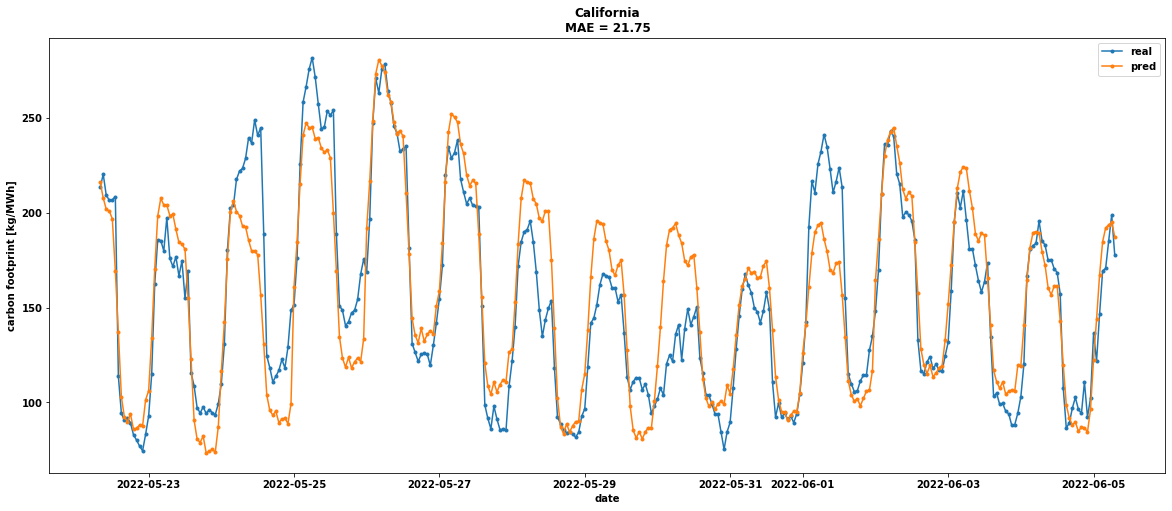

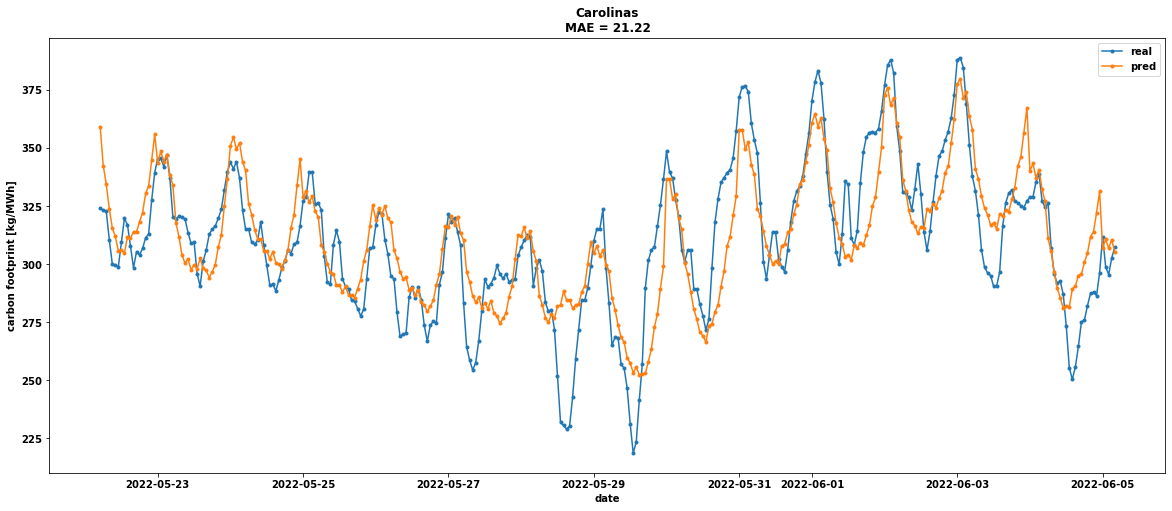

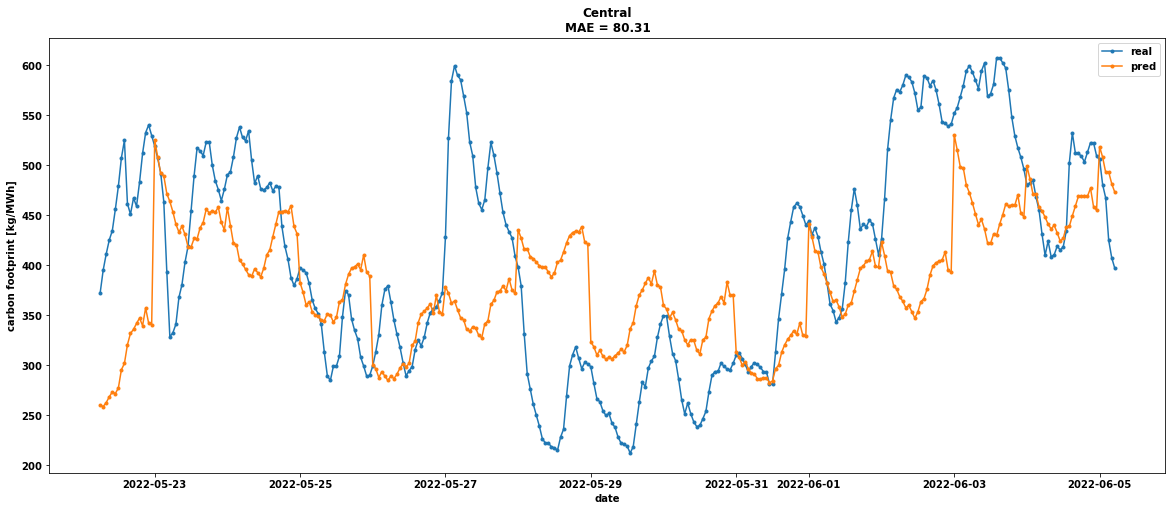

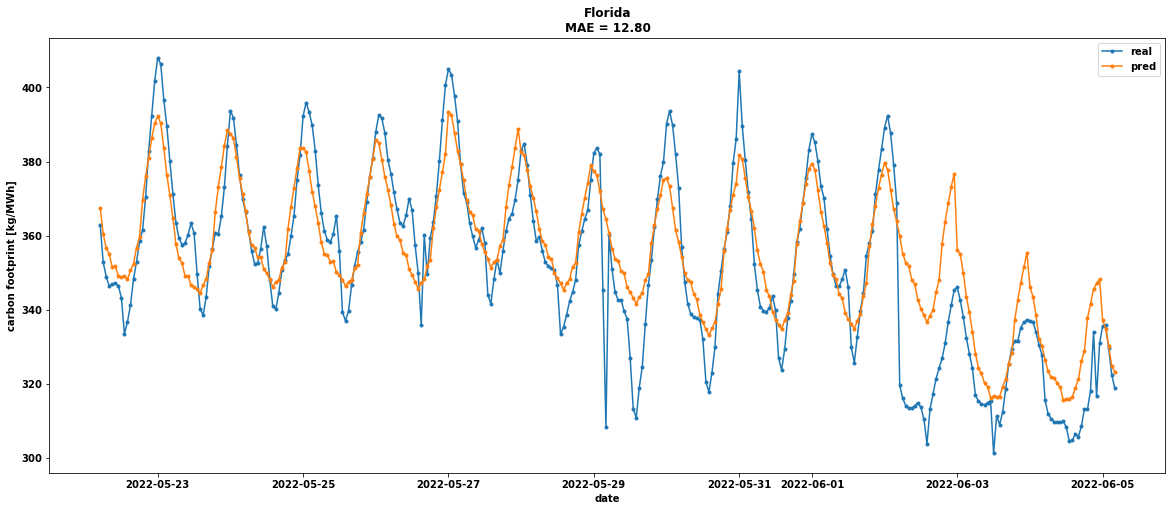

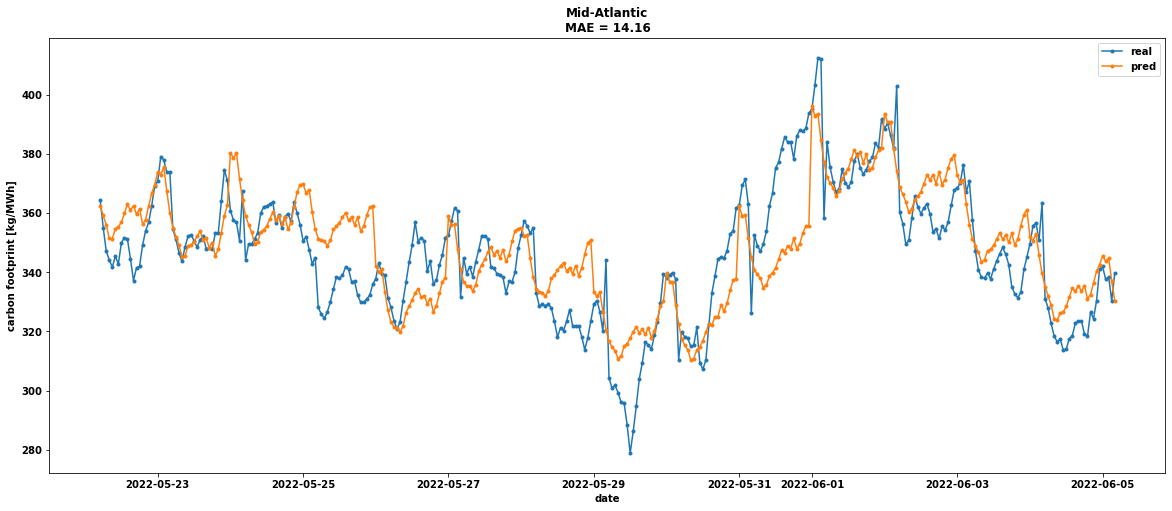

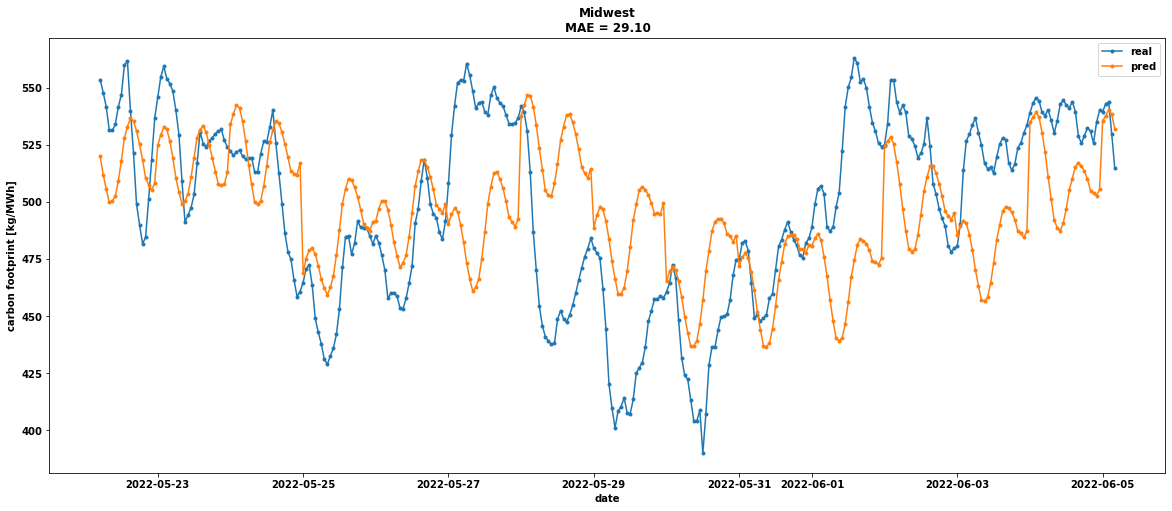

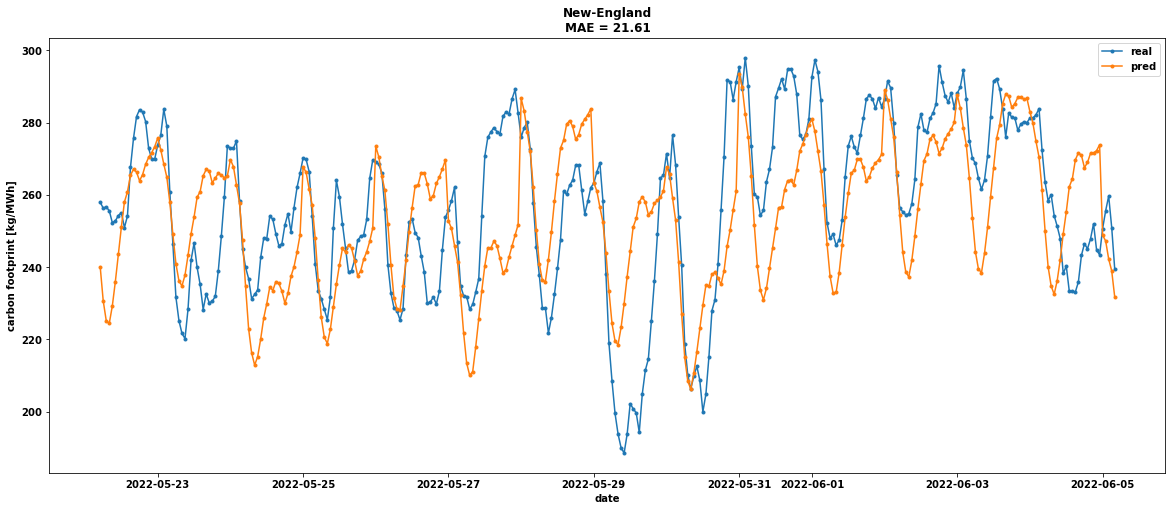

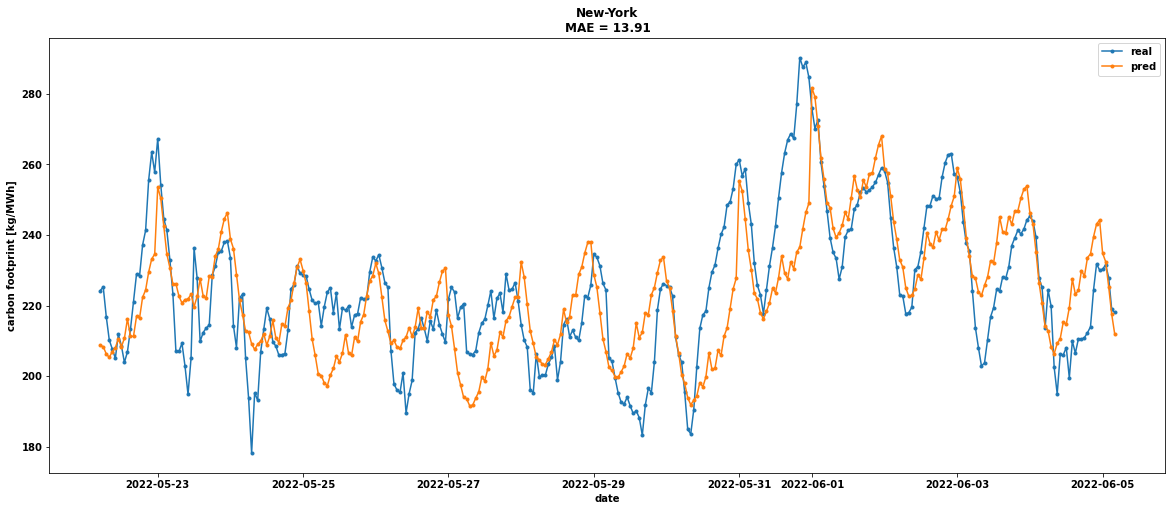

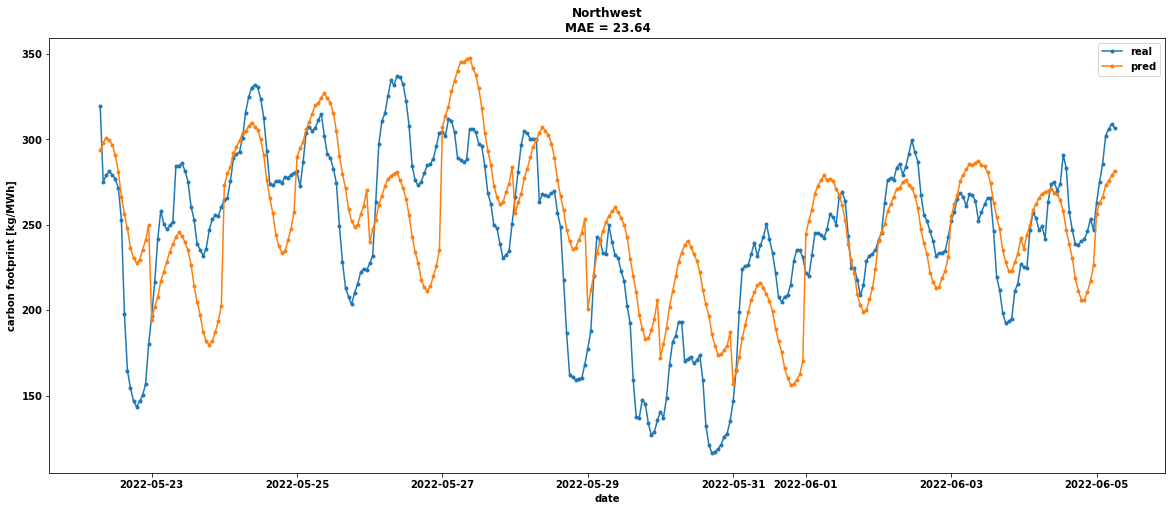

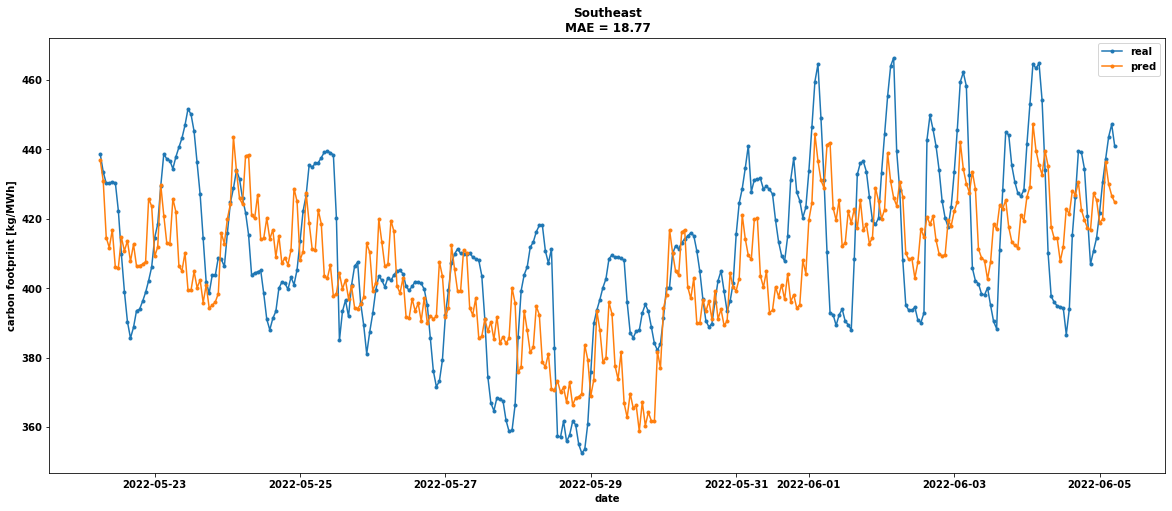

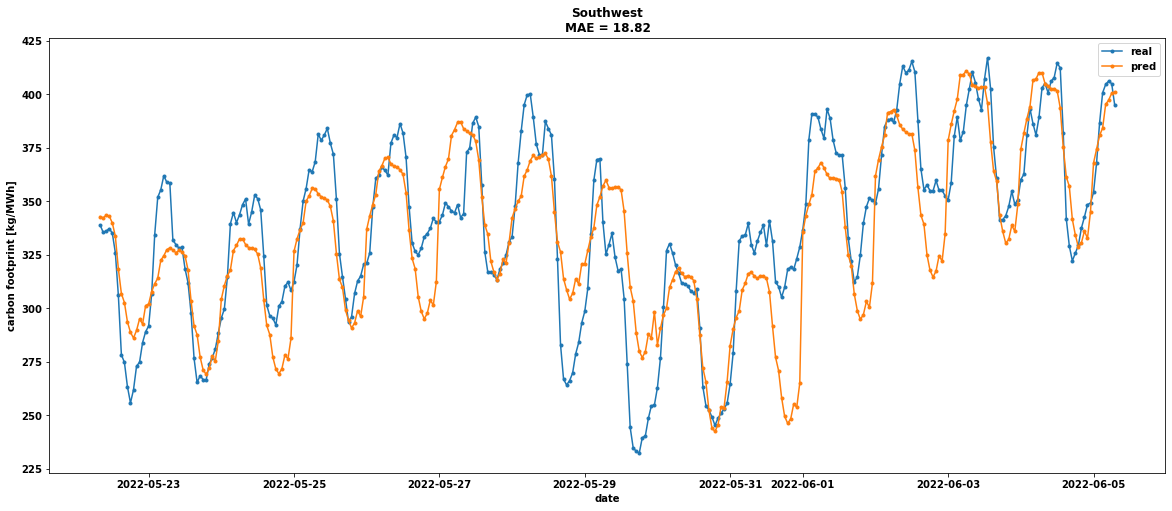

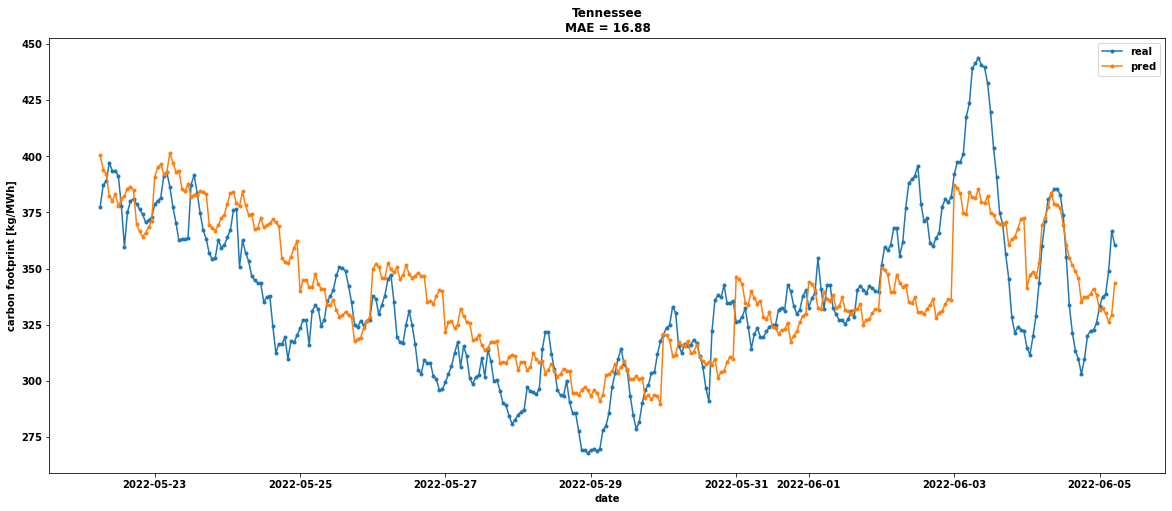

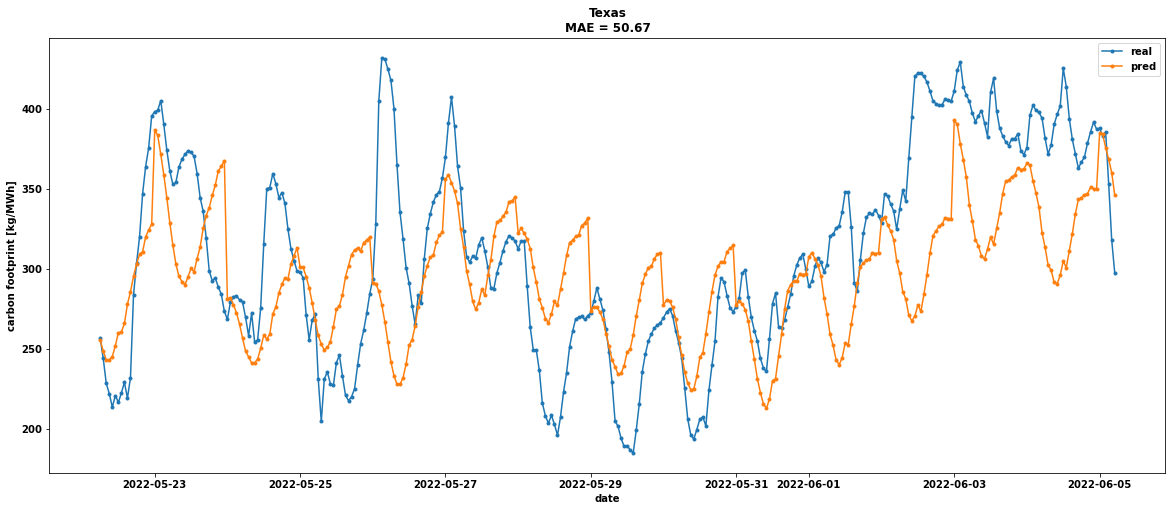

In [33]:
for state, df, pred_dict in zip(state_list, df_list, preds_list):
    
    x = list(pred_dict.keys())
    preds = list(pred_dict.values())
    real = df.loc[df.datetime.dt.year >= 2022, "carbon_per_MWh"].to_numpy()
    
    mae = np.mean(np.abs(real-preds))
    
    n = 14*24
    x, preds, real = x[-n:], preds[-n:], real[-n:]
    
    f = plt.figure(figsize=(20,8))
    plt.plot(x, real, '.-', label="real")
    plt.plot(x, preds, '.-', label="pred")
    plt.title(f"{state}\nMAE = {mae:.2f}")
    plt.xlabel("date")
    plt.ylabel("carbon footprint [kg/MWh]")
    plt.legend()
    plt.show()